In [1]:
import matplotlib as mpl
from numpy import dtype

from ecoli.variants.new_gene_internal_shift import get_new_gene_ids_and_indices
from wholecell.utils.modular_fba import solver

mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import polars as pl
import itertools
import warnings
from scipy.sparse import csr_matrix
from scipy import stats
import scipy.ndimage as ndimage
from textwrap import wrap

import cvxpy as cp

import pandas as pd
import statsmodels.api as sm 

sns.set_style("whitegrid")
sns.set_palette("Set2")
sns.set_context("paper")
warnings.filterwarnings(action='ignore')

RELOAD_ACCESSION_DATA = False

In [2]:
def read_names(file_path):
    return np.genfromtxt(file_path, dtype=str, delimiter="\n")

complex_ids = read_names("data/complex_ids.txt")
monomer_ids = read_names("data/protein_ids.txt")
cofactor_ids = read_names("data/cofactor_ids.txt")
element_ids = read_names("data/element_ids.txt")
protein_ids = complex_ids.tolist() + monomer_ids.tolist()

# Reading the matrix CSV files
def read_matrix(file_path, sparse=False):
    # add sparse matrix reading
    if sparse:
        return csr_matrix(pl.read_csv(file_path, has_header=False).to_numpy())
    else:
        return pl.read_csv(file_path, has_header=False).to_numpy()

C = read_matrix("data/C_matrix.csv", sparse=True)
P = read_matrix("data/P_matrix.csv", sparse=True)
E = read_matrix("data/E_matrix.csv", sparse=True)
Tree = read_matrix("data/tree_matrix.csv", sparse=True)
tree_ids = complex_ids.tolist() + monomer_ids.tolist() + cofactor_ids.tolist()

total_counts_min = read_matrix("data/counts.csv")

element_isotope_mapping = {"MG": "25Mg", "MG2": "26Mg", "GA": "71Ga", "GE":"73Ge", "SI": "29Si", "P": "31P", "S": "34S", "CA":"44Ca",
                           "MN": "55Mn", "CU": "63Cu", "MO": "95Mo", "NI": "60Ni", "FE":"56Fe", 
                           "ZN": "66Zn", "W": "182W", "CO": "59Co",
                           "CD": "111Cd", "PB": "208Pb", "CR": "52Cr", "V": "51V", "SE": "77Se", "HG": "202Hg", "AS": "75As", "SB": "121Sb", "TL": "205Tl",
                           "AL": "27Al", "TI": "47Ti", "TI2": "48Ti", "FE2": "57Fe", "IN": "115In", "SN": "118Sn","BI": "209Bi",}
# reverse mapping
isotope_element_mapping = {v: k for k, v in element_isotope_mapping.items()}

## import conversion table

In [3]:
conversion_df = pl.read_csv("external_data/metalloproteome_exp_conversion.csv")

# get all unique values of End and Index
end_values = conversion_df["End"].unique().to_list()
index_values = conversion_df["Index"].unique().to_list()

# give each unique value a unique number
end_dict = {end: i for i, end in enumerate(end_values)}
index_dict = {index: i for i, index in enumerate(index_values)}

# create a new column for the unique value
conversion_df = conversion_df.with_columns(x=pl.col("End").replace(end_dict))
conversion_df = conversion_df.with_columns(y=pl.col("Index").replace(index_dict))

# drop start end index
conversion_df = conversion_df.drop(["Start", "End", "Index"])

conversion_df

Experiment,x,y
str,i64,i64
"""0to0_1""",0,0
"""0to0_2""",0,1
"""0to0_3""",0,2
"""0to0_4""",0,3
"""0to0_5""",0,4
…,…,…
"""900to1000_28""",17,27
"""900to1000_29""",17,28
"""900to1000_30""",17,29


In [4]:
conversion_df.filter(pl.col("Experiment") == "400to450_10")

Experiment,x,y
str,i64,i64
"""400to450_10""",9,9



## Import protein data

In [5]:
import requests
import xml.etree.ElementTree as ET
import time

if RELOAD_ACCESSION_DATA:
    for accession_id in prot_df["Accession Number"]:
        
        if accession_id not in gene_dict:
            # add a 0.1 second delay between each request
            time.sleep(1)
            
            # Step 1: Use elink to find the Gene ID associated with the protein accession
            elink_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi?dbfrom=protein&db=gene&id={accession_id}&retmode=xml"
            elink_response = requests.get(elink_url)
            elink_tree = ET.fromstring(elink_response.content)
            
            # Extract the Gene ID from the elink response
            gene_id = None
            for linkset in elink_tree.findall(".//LinkSetDb"):
                if linkset.find("LinkName").text == "protein_gene" and linkset.find(".//Id") is not None:
                    gene_id = linkset.find(".//Id").text
                    break
            
            # Step 2: Use esummary to get the gene information based on the Gene ID
            if gene_id:
                esummary_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id={gene_id}&retmode=xml"
                esummary_response = requests.get(esummary_url, headers=headers)
                esummary_tree = ET.fromstring(esummary_response.content)
                
                # Extract the gene name
                gene_name = esummary_tree.find(".//Name").text
                print(f"Gene name: {gene_name}")
            else:
                print("Gene ID not found.")
                
            gene_dict[accession_id] = gene_name

In [6]:
# load gene df
gene_df = pl.read_csv("data/accession_gene_dict.csv")
gene_df

# convert to dict
gene_dict = dict(zip(gene_df["Accession Number"], gene_df["Gene Name"]))

gene_df

Accession Number,Gene Name
str,str
"""AAC76954.1""","""tufB"""
"""AAC76345.1""","""rplC"""
"""AAC76328.1""","""rpsE"""
"""AAC74990.1""","""fliC"""
"""AAC77103.1""","""groL"""
…,…
"""AAC75718.1""","""ygaC"""
"""AAC73987.1""","""ycaK"""
"""AAC77128.1""","""miaA"""


In [7]:
gene_df.filter(pl.col("Gene Name") == "ydgH")

Accession Number,Gene Name
str,str
"""AAC74676.1""","""ydgH"""


## Change column to gene name

In [8]:
# Load the data
prot_df_raw = pl.read_csv('external_data/metalloproteome_proteins.csv')

# drop "#", "Visible?", "Starred?", "Molecular Weight"
prot_df = prot_df_raw.drop(["#", "Visible?", "Starred?", "Molecular Weight", "Taxonomy"])

prot_df.head(5)

# change column to gene name
prot_df = prot_df.with_columns(Gene=pl.col("Accession Number").replace(gene_dict))

# drop Identified Proteins (1235), Accession Number
prot_df = prot_df.drop(["Identified Proteins (1235)", "Accession Number"])

# drop duplicate rows with the same gene name
prot_df = prot_df.unique(subset=["Gene"], maintain_order=True)

# transpose and keep gene as column names
prot_exp_names = list(prot_df.columns)[:-1]
gene_names = prot_df["Gene"].to_list()

In [9]:
# transpose and keep gene as column names
prot_df = prot_df.drop(["Gene"]).transpose()
prot_df.columns = gene_names

# add a new column, "Experiment"
prot_df = prot_df.with_columns(pl.Series(name="Experiment", values=prot_exp_names))

# join with the conversion table
prot_df = prot_df.join(conversion_df, on="Experiment")

prot_df

tufB,rplC,rpsE,fliC,groL,rpsT,rplD,rplX,rplR,rpsL,rplO,rplM,rpsA,rplV,icd,ilvC,rpsG,rpsN,rplN,rplB,rpsU,rplA,rplU,rpmB,carB,metE,eno,fusA,rpoB,rpoC,rpsI,hupA,rpsS,gapA,dppA,rpmD,oppA,…,tdh,hemN,chaB,yjhU,putA,hemF,efeB,paaY,yciG,yidC,dnaQ,fliK,yrdB,ybhB,yfaY,dnaJ,ybeL,fliD,ubiJ,ydeI,eutL,rarA,uxaC,tcdA,nikA,tolQ,ydcI,yedD,murB,ygaC,ycaK,miaA,fruK,ubiF,Experiment,x,y
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_1""",0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_2""",0,1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_3""",0,2
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_4""",0,3
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_5""",0,4
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""900to1000_28""",17,27
0,0,6,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""900to1000_29""",17,28
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""900to1000_30""",17,29


## Load the metal data

In [10]:
# load metal data
metal_df = pl.read_csv('external_data/metalloproteome_metals.csv')

# drop columns that started with "_dupli"
metal_df = metal_df.drop([col for col in metal_df.columns if col.startswith("_dupli")])

# drop columns without names
metal_df = metal_df.drop([col for col in metal_df.columns if len(col) < 2])

# for all float cols, subtract minimum value
# for col in metal_df.columns:
#     if metal_df[col].dtype == pl.Float64:
#         metal_df = metal_df.with_columns(pl.Series(name=col, values=metal_df[col] - 0.999 * metal_df[col].min()))

# extract list of metals
metals = metal_df.columns[1:]

metal_df

Experiment,25Mg,26Mg,29Si,31P,34S,44Ca,71Ga,73Ge,27Al,47Ti,48Ti,51V,52Cr,55Mn,56Fe,57Fe,59Co,60Ni,63Cu,66Zn,75As,77Se,95Mo,111Cd,115In,118Sn,121Sb,182W,202Hg,208Pb,209Bi
str,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""0to0_1""",8823,11681,189919,328,3591,22496,38,6,86.974396,4.004968,5.167747,0.179796,0.876813,10.836837,10.552461,10.337697,0.057026,1.173599,0.500182,0.602304,0.0222,0.119779,0.117428,0.00104,-13.836556,0.09528,0.007665,40.403296,3.449361,0.016148,9.993649
"""0to0_2""",868,1179,180574,300,3436,7186,4,1,1.353013,0.095871,0.377731,0.108823,0.728478,6.006004,2.958434,2.69667,0.048106,1.077893,0.339914,0.524031,0.013567,0.299447,0.117188,0.000208,-13.536126,0.056937,0.007508,35.564532,2.891377,0.010286,10.862665
"""0to0_3""",831,1205,182317,291,3581,7155,1,0,1.516522,0.100229,0.403266,0.116908,0.722591,5.784571,3.121333,2.888219,0.056345,1.111941,0.300745,0.542167,0.013567,0.059889,0.114162,0.00104,-13.595515,0.044946,0.007039,37.500017,2.536294,0.00858,9.993649
"""0to0_4""",872,1080,184990,256,3621,7330,2,0,1.600319,0.082798,0.414614,0.112477,0.746018,5.556133,3.373253,3.177696,0.080347,1.251426,0.30058,0.603577,0.0259,0.029945,0.126954,0.001873,-13.555307,0.037981,0.006804,39.193624,2.58702,0.007826,8.907374
"""0to0_5""",1006,1303,183349,294,3635,7837,3,0,1.671855,0.069725,0.442581,0.117996,0.789342,5.53877,3.598385,3.239036,0.10545,1.430548,0.480732,0.702853,0.024667,0.239558,0.11815,0.002289,-13.657827,0.037335,0.009229,43.548493,3.347909,0.011981,8.255623
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""900to1000_28""",402,597,70454,322,3812,2631,0,0,1.099329,0.082724,0.189697,0.114594,0.271328,0.044113,1.119198,0.83295,0.006293,0.169676,0.18,0.172763,0.014881,0.159694,0.073712,0.0,-15.342357,0.021587,0.00541,18.588133,1.491532,0.003633,3.698081
"""900to1000_29""",431,557,71339,321,3947,2585,3,0,1.144876,0.078128,0.171669,0.112909,0.262306,0.041008,1.146955,0.85173,0.006668,0.180365,0.176192,0.168419,0.017362,0.031939,0.076596,0.000631,-15.345479,0.023709,0.004199,22.796756,1.789838,0.003382,4.88147
"""900to1000_30""",743,946,67673,268,3814,2738,1,0,1.115892,0.045958,0.195433,0.108098,0.225865,0.070682,1.009749,0.69928,0.00599,0.202633,0.174884,0.269673,0.019842,0.127755,0.074627,0.000421,-15.180415,0.022758,0.004441,16.133086,2.336734,0.004481,4.141853


<Axes: ylabel='66Zn'>

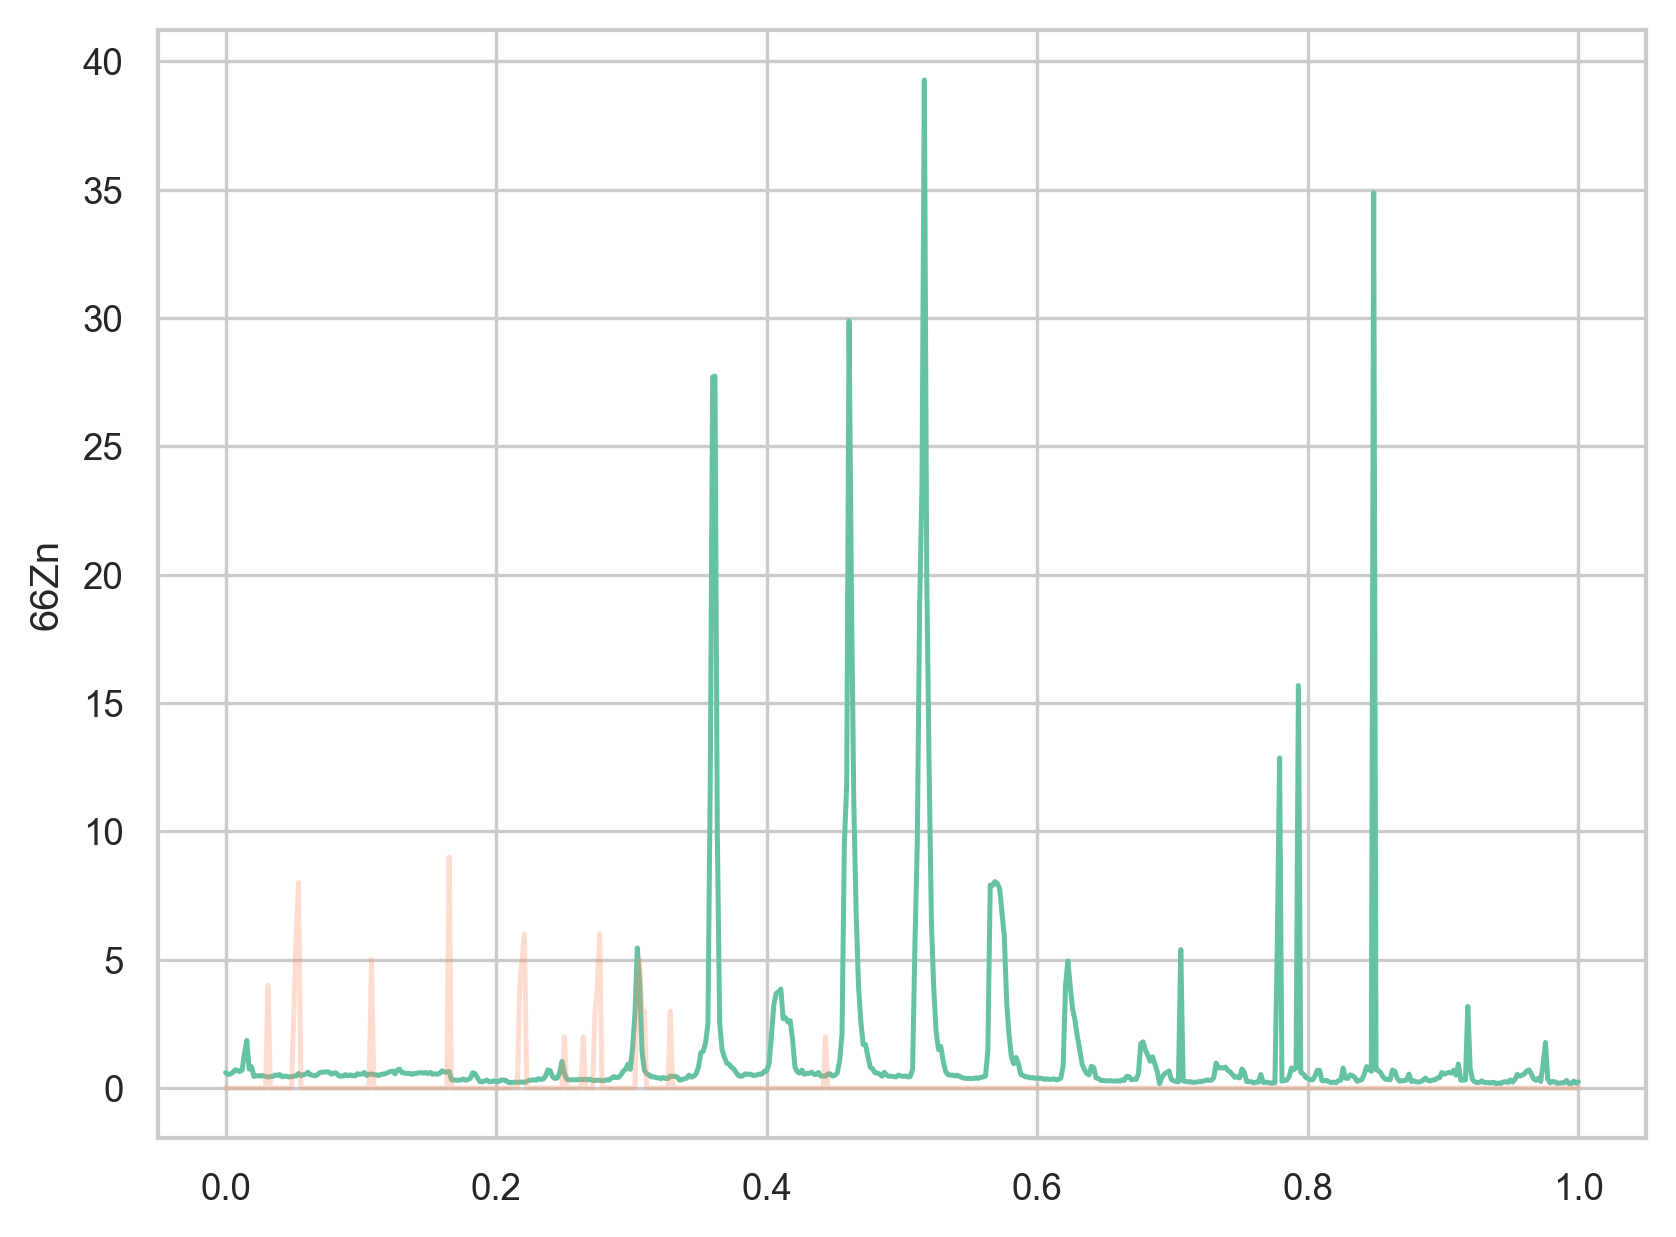

In [11]:
n_samples  = metal_df.shape[0]
linspace = np.linspace(0, 1, n_samples)

sns.lineplot(x=linspace, y="66Zn", data=metal_df)

# plot rpmE col
sns.lineplot(x=linspace, y="rpmE", data=prot_df, alpha=0.3)

# Join the metalloproteome data with the conversion table

In [12]:
# join the data
metal_join_df = metal_df.join(conversion_df, on="Experiment")

x_min = 3
y_min = 1

x_max = 15
y_max = 26


# filter out edges
# if x or y are 0, or x=17 or y=31, remove them.
metal_join_df = metal_join_df.filter((pl.col("x") >= x_min) & (pl.col("y") >= y_min) & (pl.col("x") <= x_max) & (pl.col("y") <=y_max))
prot_df = prot_df.filter((pl.col("x") >= x_min) & (pl.col("y") >= y_min) & (pl.col("x") <= x_max) & (pl.col("y") <= y_max))

metal_join_df

Experiment,25Mg,26Mg,29Si,31P,34S,44Ca,71Ga,73Ge,27Al,47Ti,48Ti,51V,52Cr,55Mn,56Fe,57Fe,59Co,60Ni,63Cu,66Zn,75As,77Se,95Mo,111Cd,115In,118Sn,121Sb,182W,202Hg,208Pb,209Bi,x,y
str,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
"""100to150_2""",2424,3268,358150,658,10318,10690,4,2,1.28963,0.105418,0.23391,0.20744,0.437886,0.994977,1.57962,1.247038,0.036616,0.831977,0.229864,0.30864,0.014489,0.200652,0.081377,0.001336,-13.40308,0.038449,0.004793,12.471815,2.004132,0.00593,4.187315,3,1
"""100to150_3""",2404,3293,353562,737,11082,10791,7,4,1.434155,0.086251,0.26326,0.189714,0.449281,0.965916,1.851357,1.489283,0.035843,0.854022,0.242732,0.302458,0.015648,0.183931,0.081209,0.000779,-13.505967,0.040625,0.005548,12.224868,2.077455,0.006276,3.513492,3,2
"""100to150_4""",2298,3197,346458,704,10499,10289,4,4,1.605376,0.103501,0.246314,0.187535,0.473168,0.947359,2.152927,1.808355,0.035271,0.819974,0.256623,0.304706,0.024341,0.16721,0.077411,0.001781,-13.331345,0.040189,0.005903,12.101366,2.321863,0.006496,3.248776,3,3
"""100to150_5""",2420,3155,341925,690,9885,10242,1,3,1.478341,0.093918,0.238977,0.168423,0.434999,0.926318,1.782944,1.457018,0.03481,0.787764,0.273798,0.312854,0.017386,0.066884,0.079091,0.000668,-13.197517,0.038805,0.005015,13.95364,2.24854,0.006416,3.561624,3,4
"""100to150_6""",2276,3048,329445,753,10192,10398,2,1,1.46177,0.113085,0.252254,0.170305,0.443807,0.90726,1.764867,1.436532,0.036868,0.797316,0.261809,0.34882,0.016227,0.183931,0.078738,0.001002,-13.089512,0.034137,0.004616,12.348343,2.224101,0.00667,3.3691,3,5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""700to800_23""",687,1066,62194,282,3446,4018,0,1,0.968749,0.067557,0.266934,0.100142,0.235307,0.12268,1.015955,0.727855,0.008304,0.205888,0.172192,0.322502,0.021042,0.265612,0.074713,0.000638,-14.964736,0.022933,0.00529,20.51376,1.913082,0.004284,5.048914,15,22
"""700to800_24""",1032,1291,63460,280,3725,5395,1,1,2.75897,0.117098,0.31536,0.101578,0.232665,0.127879,1.182385,0.9304,0.009572,0.23914,0.192601,0.541271,0.017096,0.265612,0.091301,0.000638,-15.408186,0.083402,0.005208,19.536919,1.647375,0.005147,9.42467,15,23
"""700to800_25""",576,809,65263,326,3752,3352,1,1,1.023242,0.076564,0.206102,0.107803,0.262816,0.119358,1.022619,0.776596,0.008429,0.220881,0.171453,0.253877,0.015781,0.132806,0.076556,0.001064,-15.137232,0.026768,0.004394,14.327084,1.753658,0.004305,4.039135,15,24


<Axes: ylabel='66Zn'>

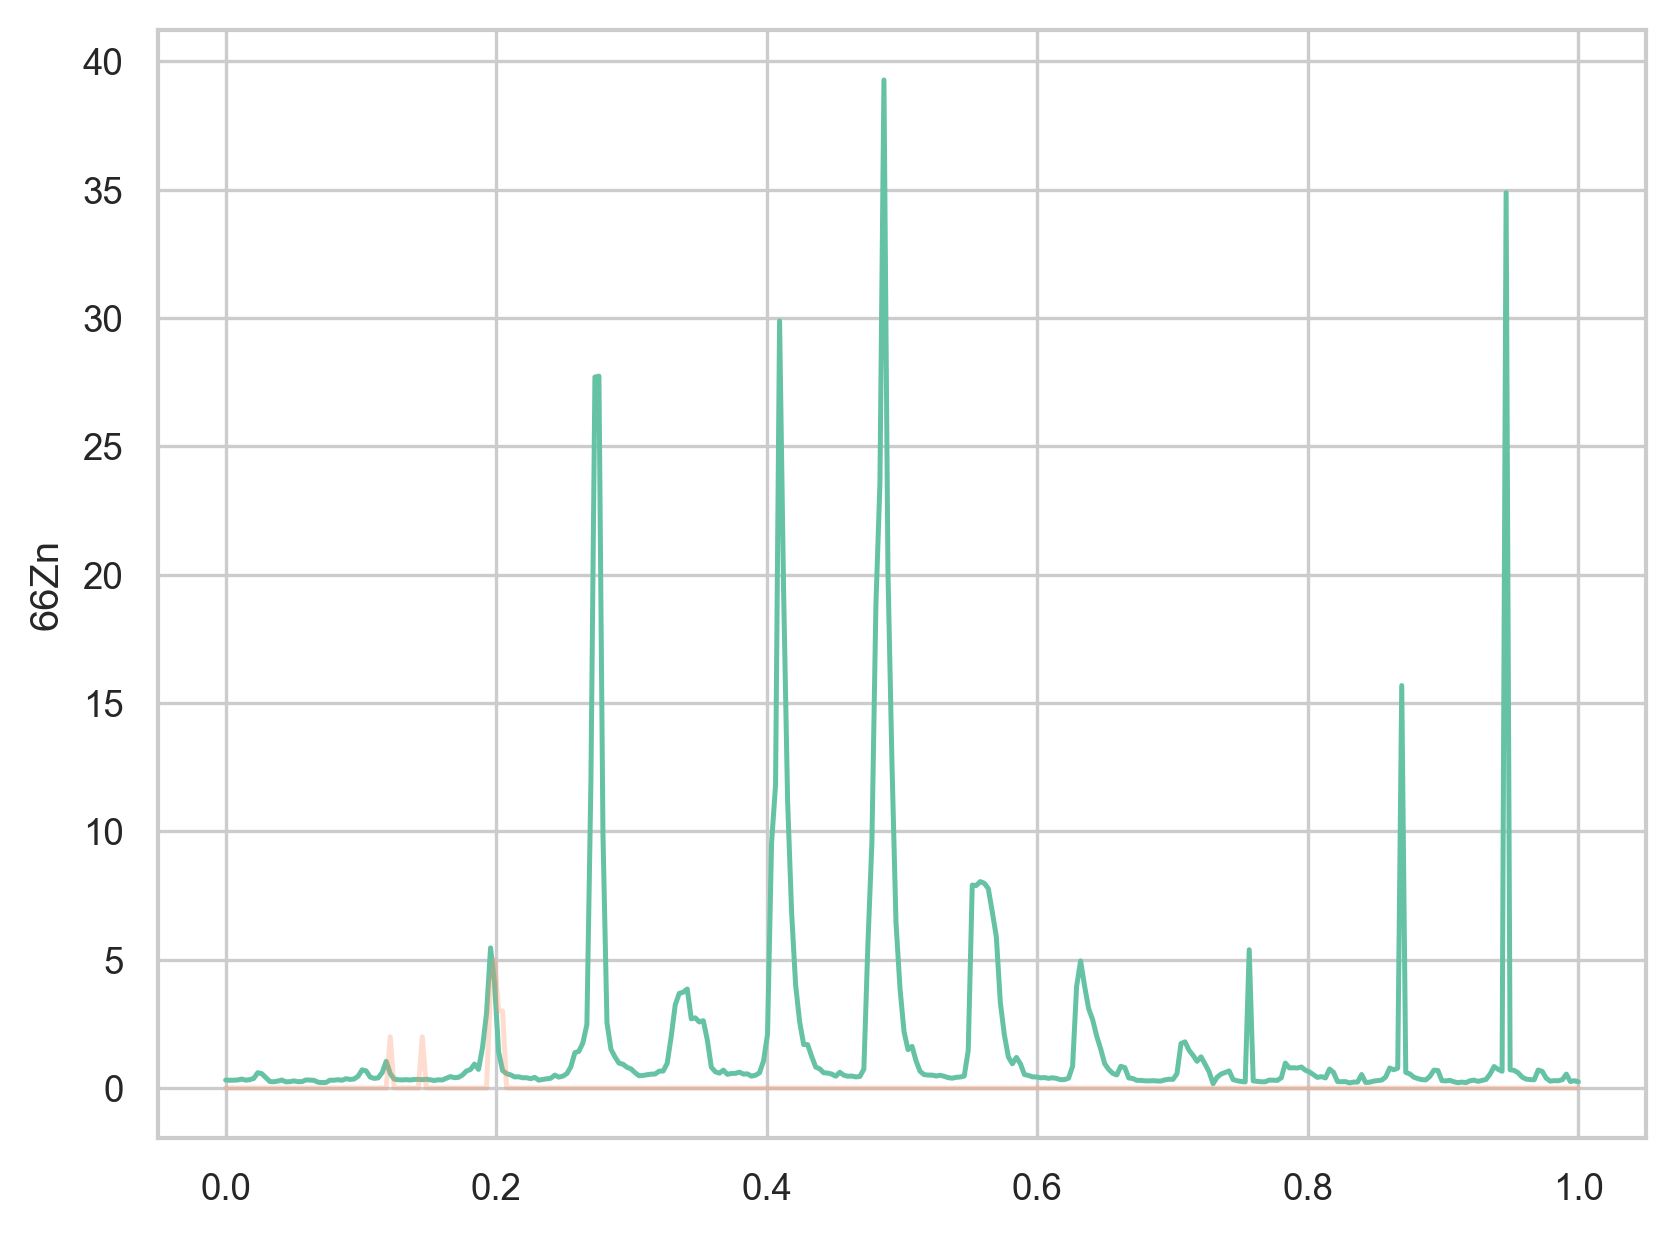

In [13]:
n_samples  = metal_join_df.shape[0]
linspace = np.linspace(0, 1, n_samples)

sns.lineplot(x=linspace, y="66Zn", data=metal_join_df)

# plot rpmE col
sns.lineplot(x=linspace, y="rpmE", data=prot_df, alpha=0.3)

# Import simulation data and conversion tables

In [14]:
# make protein-element mapping
elements = ["FE", "ZN", "MN", "CU", "MO", "NI"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]


# get name conversion table
gene_name_table = pl.read_csv("external_data/ecocyc_name_conversion.txt", separator="\t")

# rename cols to "Protein ID", "EcoCyc ID", "Accession Number", "Gene name"
gene_name_table.columns = ["Protein ID", "EcoCyc ID", "Accession Number", "Gene name"]

# get corresponding gene name for each protein
gene_name_table = gene_name_table.filter(pl.col("Protein ID").is_in(monomer_ids))

# make a mapping
gene_to_prot_dict = dict(zip(gene_name_table["Gene name"], gene_name_table["Protein ID"]))
prot_to_gene_dict = dict(zip(gene_name_table["Protein ID"], gene_name_table["Gene name"]))

# convert gene_names list to protein id list
detected_protein_ids = [gene_to_prot_dict[gene_name] for gene_name in gene_names if gene_name in gene_to_prot_dict]
# get indices of genes in gene dict
gene_indices = [gene_names.index(gene_name) for gene_name in gene_names if gene_name in gene_to_prot_dict]

# for each protein id, index it in the monomer_ids
detected_protein_idx = [monomer_ids.tolist().index(protein_id) for protein_id in detected_protein_ids]


In [15]:
monomer_to_complex_dict = {}

# create monomer to complex dict
for i, protein_id in enumerate(monomer_ids):
    if protein_id in monomer_ids:

        # get indices where C[:, i] is nonzero
        complex_indices = np.where(C[:, i].toarray() > 0)[0]

        # save complex_id if it doesn't match the protein_id
        complex_id = [protein_ids[idx] for idx in complex_indices if protein_ids[idx] != protein_id]

        # check in Tree if complex_id has parents by checking sum
        complex_parents = [Tree[:, tree_ids.index(complex_id)].sum() for complex_id in complex_id]

        # if complex_id doesn't have parents, select it
        for j, complex_id_idx in enumerate(complex_id):
            if complex_parents[j] == 0:
                monomer_to_complex_dict[protein_id] = complex_id[j]

                # if len(complex_id) > 1:
                    # print(f"Multiple complex ids found for protein: {protein_id}, complex ids: {complex_id}. Picked {complex_id[j]}")




In [16]:
elements = ["FE", "ZN", "MN", "CU", "MO", "NI"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

sim_prot_metal = np.diag(total_counts_min.mean(axis=0) @ C) @ P @ E[:, element_indices]

# divide by col sums
sim_prot_metal = sim_prot_metal / sim_prot_metal.sum(axis=0)

sim_prot_metal_df = pl.DataFrame(sim_prot_metal, schema=elements)
sim_prot_metal_df = sim_prot_metal_df.with_columns(pl.Series(name="Protein ID", values=monomer_ids))
sim_prot_metal_df = sim_prot_metal_df.with_columns(pl.Series(name="Gene",
                                                             values=[prot_to_gene_dict[protein_id]  if protein_id in prot_to_gene_dict else "None" for protein_id in sim_prot_metal_df["Protein ID"]]))

# only include genes found in the experimental data
sim_prot_metal_df = sim_prot_metal_df.filter(pl.col("Gene").is_in(gene_names))

# use monomer_to_complex_dict to add complex id column by using polars replace
sim_prot_metal_df = sim_prot_metal_df.with_columns(pl.Series(name="Complex ID", values=sim_prot_metal_df["Protein ID"].replace(monomer_to_complex_dict)))


sim_prot_metal_df

FE,ZN,MN,CU,MO,NI,Protein ID,Gene,Complex ID
f64,f64,f64,f64,f64,f64,str,str,str
0.0,0.0,0.0,0.0,0.0,0.0,"""1-PFK-MONOMER""","""fruK""","""1-PFK"""
0.0,0.0,0.0,0.0,0.0,0.0,"""2-ISOPROPYLMALATESYN-MONOMER""","""leuA""","""2-ISOPROPYLMALATESYN-MONOMER"""
0.0,0.0,0.0,0.0,0.0,0.0,"""2-OCTAPRENYL-METHOXY-BENZOQ-ME…","""ubiE""","""CPLX0-8301"""
0.0,0.0,0.0,0.0,0.0,0.0,"""3-CH3-2-OXOBUTANOATE-OH-CH3-XF…","""panB""","""3-METHYL-2-OXOBUT-OHCH3XFER-CP…"
0.0,0.0,0.0,0.0,0.0,0.0,"""3-ISOPROPYLMALDEHYDROG-MONOMER""","""leuB""","""3-ISOPROPYLMALDEHYDROG-CPLX"""
…,…,…,…,…,…,…,…,…
0.0,0.0,0.0,0.0,0.0,0.0,"""YJJK-MONOMER""","""ettA""","""YJJK-MONOMER"""
0.0,0.0,0.0,0.0,0.0,0.0,"""YLIB-MONOMER""","""gsiB""","""ABC-49-CPLX"""
0.0,0.0,0.0,0.0,0.0,0.0,"""YNEA-MONOMER""","""lsrB""","""ABC-58-CPLX"""


# Plot unprocessed data

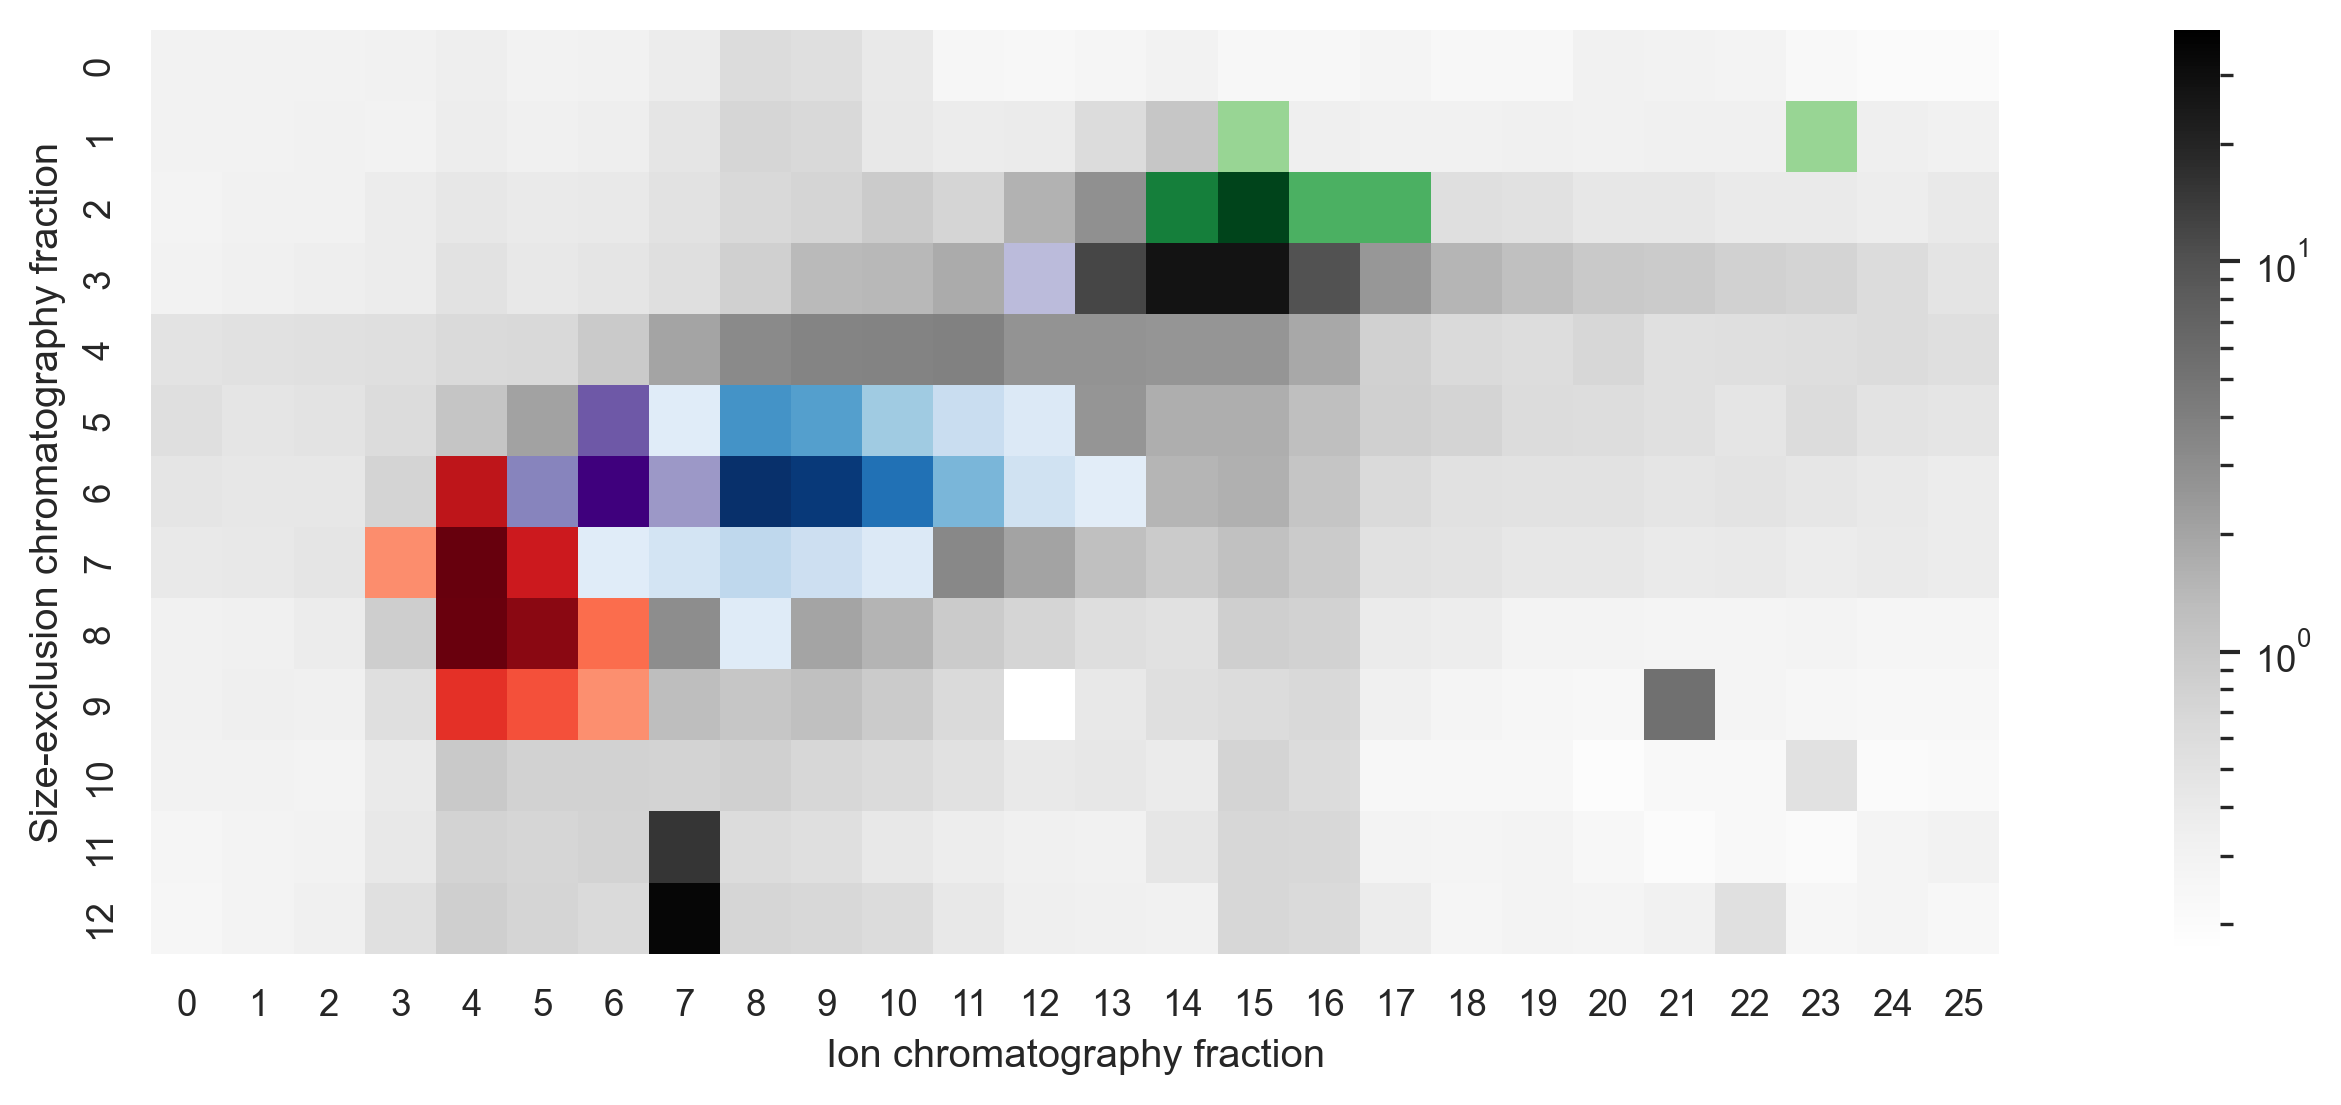

In [17]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(15, 4))

# heatmap of 56Fe data against x and y
sns.heatmap(metal_join_df.pivot("66Zn", "x", "y", )[:, 1:], cmap="Grays", square=True, cbar=True, norm=LogNorm())
sns.heatmap(prot_df.pivot("metE", "x", "y", )[:, 1:], mask=(prot_df.pivot("metE", "x", "y", ) < 50).to_numpy()[:, 1:], 
            cmap="Blues", square=True, cbar=False, vmin=0)
sns.heatmap(prot_df.pivot("rpmE", "x", "y", )[:, 1:], mask=(prot_df.pivot("rpmE", "x", "y", ) < 1).to_numpy()[:, 1:], 
            cmap="Greens", square=True, vmin=0, cbar=False)
sns.heatmap(prot_df.pivot("rpoC", "x", "y", )[:, 1:], mask=(prot_df.pivot("rpoC", "x", "y", ) < 100).to_numpy()[:, 1:], 
            cmap="Reds", square=True, vmin=0, cbar=False)
sns.heatmap(prot_df.pivot("pyrI", "x", "y", )[:, 1:], mask=(prot_df.pivot("pyrI", "x", "y", ) < 80).to_numpy()[:, 1:], 
            cmap="Purples", square=True, vmin=0, cbar=False)

# change x and y axis labels
plt.ylabel("Size-exclusion chromatography fraction")
plt.xlabel("Ion chromatography fraction")

# make xticklabels and yticklabels start from x_min and y_min and end at x_max and y_max

# set xticklabels
# plt.xticks(np.arange(y_min, y_max, 1) - 0.5, np.arange(y_min, y_max, 1))
# plt.yticks(np.arange(x_min, x_max, 1) - 0.5, np.arange(x_min, x_max, 1))

# save as png and svg
plt.savefig("figures/metal_splashes.png")
plt.savefig("figures/metal_splashes.svg")


# Plot grid of heatmaps

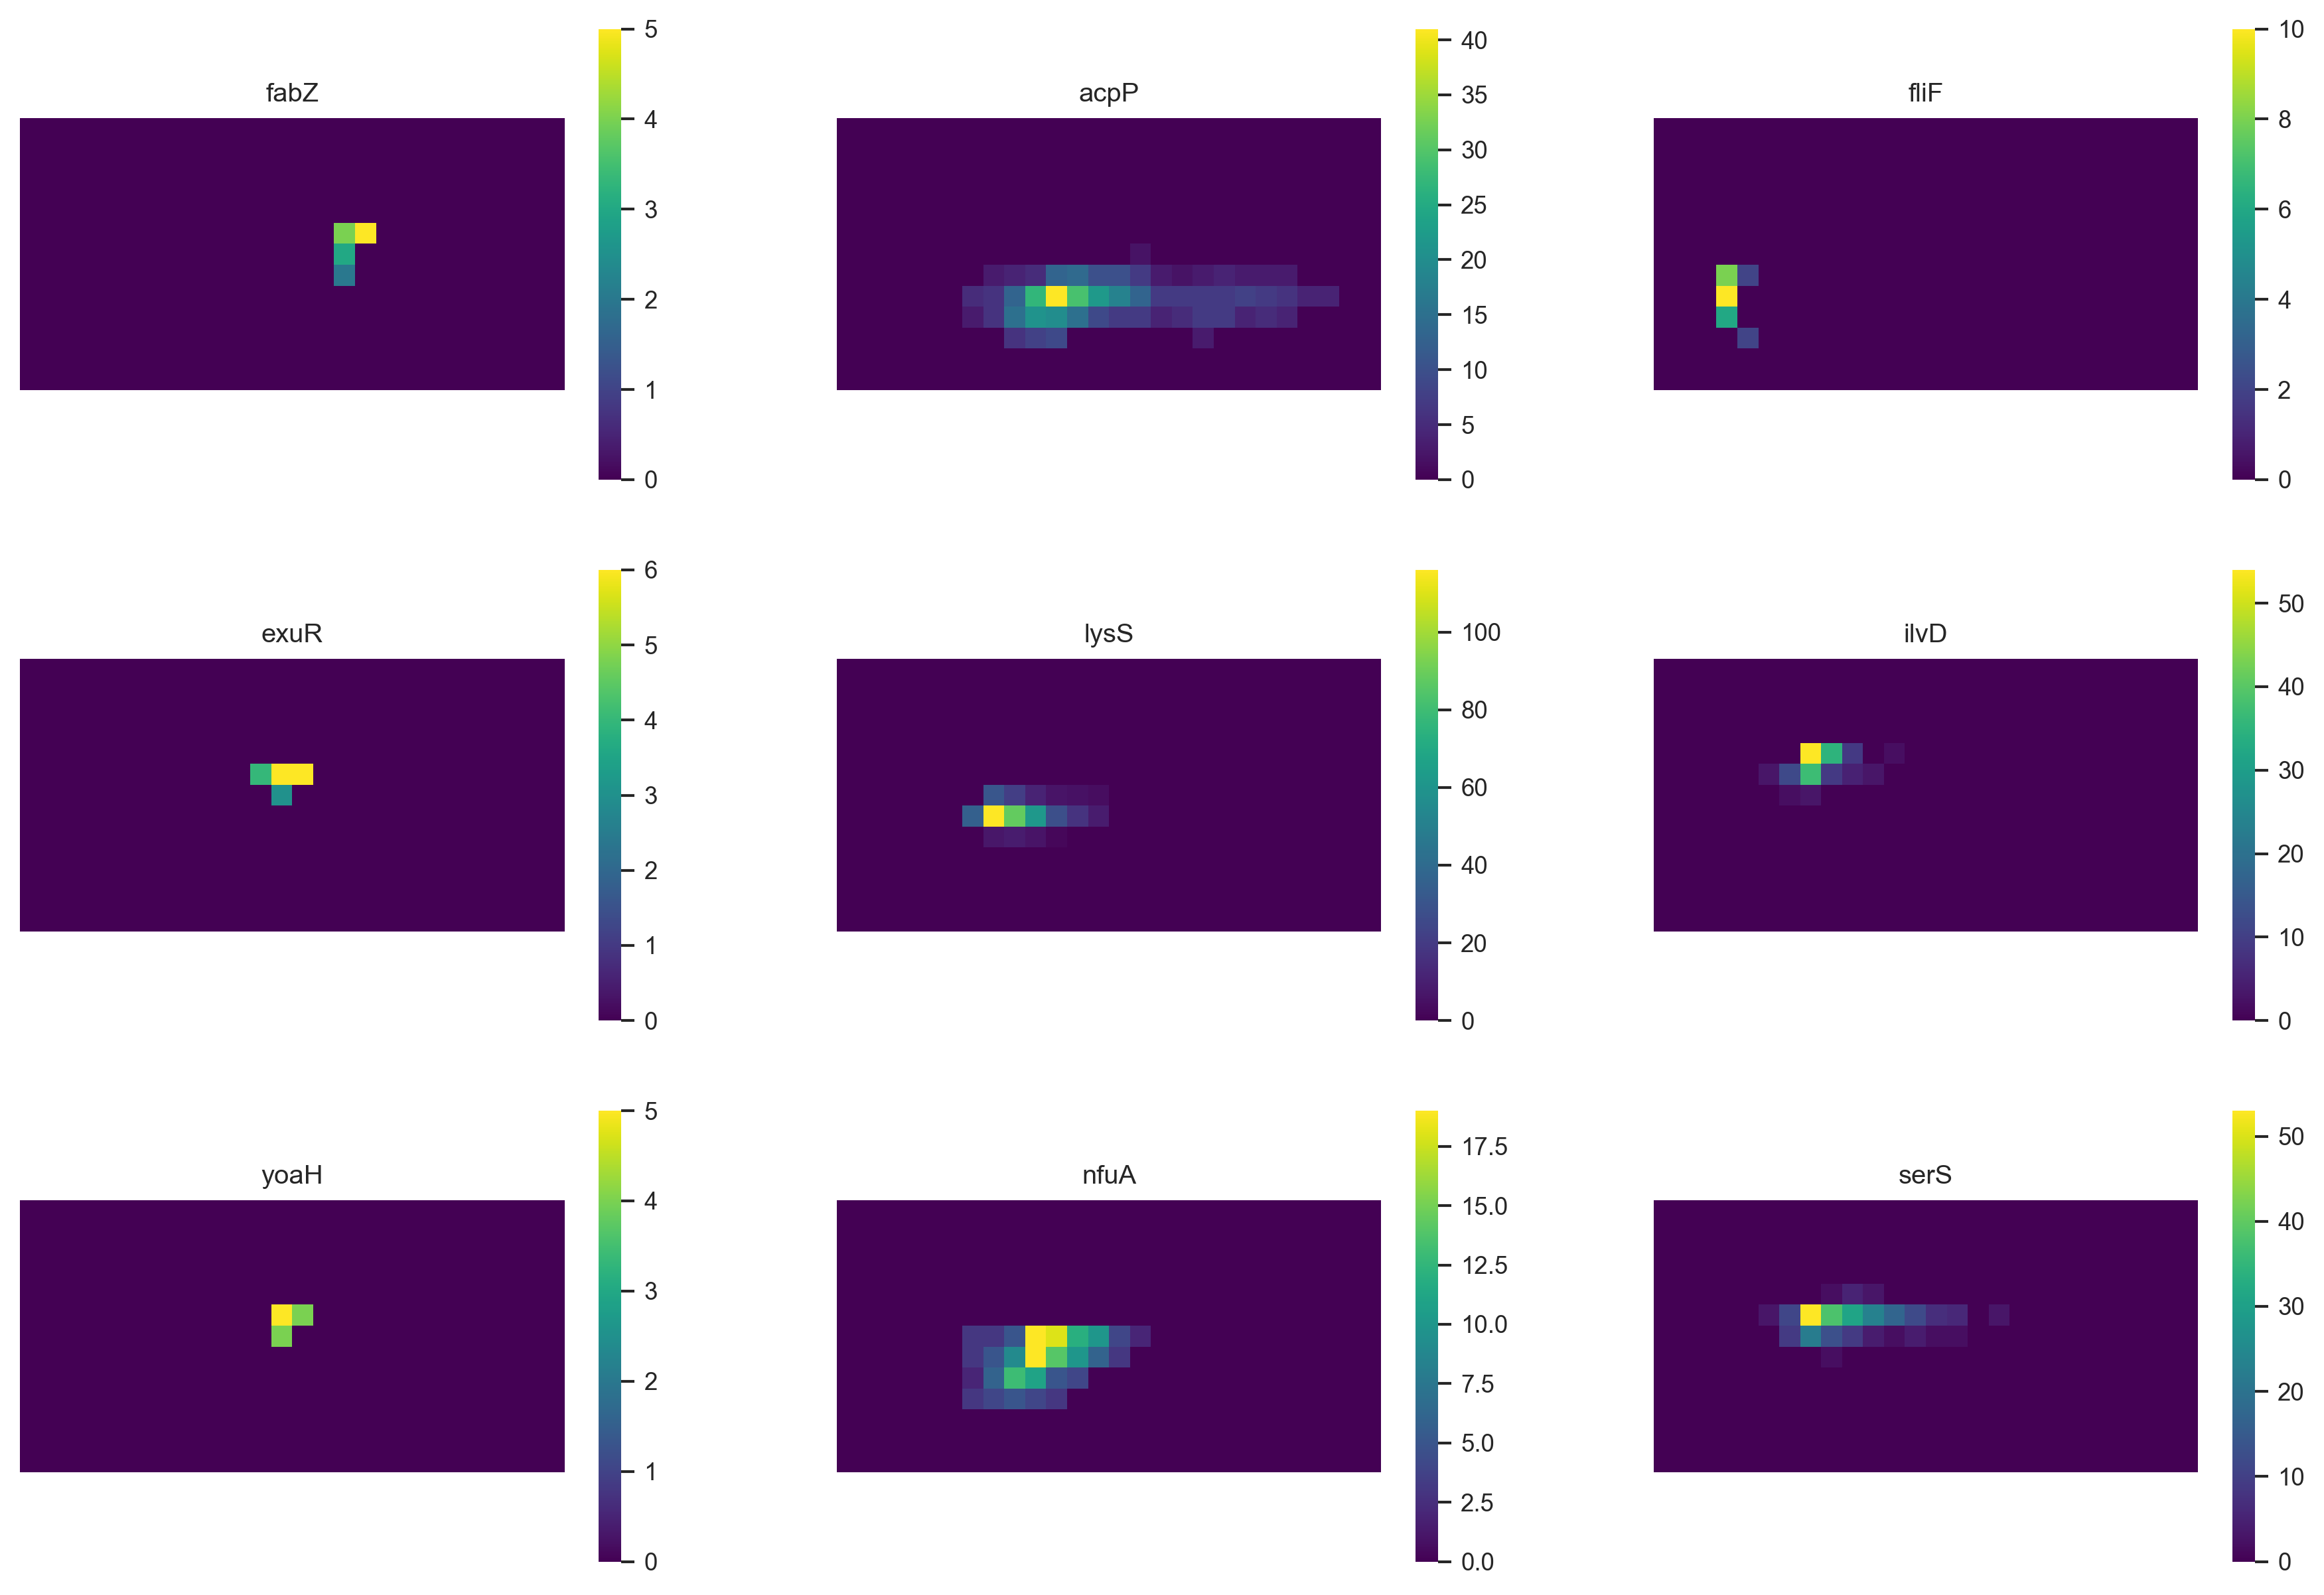

In [18]:
# for 9 random proteins, plot a grid of small heatmaps
random_proteins = np.random.choice(gene_names, 9)

fig, axs = plt.subplots(3, 3, figsize=(15, 10))
for i, ax in enumerate(axs.flatten()):
    sns.heatmap(prot_df.pivot(random_proteins[i], "x", "y", )[:, 1:], cmap="viridis", square=True, cbar=True, ax=ax)
    ax.set_title(random_proteins[i])
    ax.set_xticks([])
    ax.set_yticks([])

    ## Filter out edges

In [19]:
# For each protein, pivot and do some filtering

for protein in gene_names:
    prot_pivot = prot_df.pivot(protein, "x", "y", ).to_numpy()[:, 1:]

    # create boolean array
    prot_mask = prot_pivot > 0

    # find number of neighbours per well
    footprint = np.array([[1,1,1],
                          [1,0,1],
                          [1,1,1]])

    f = lambda x: x.sum()

    results = ndimage.generic_filter(prot_mask, f, footprint=footprint, mode="constant", cval=0)

    # get AND of the two
    prot_pivot_true_mask = prot_mask & results

    # dont zero if it would remove all the data
    if prot_pivot_true_mask.sum() > 0:
        prot_pivot[~prot_pivot_true_mask] = 0

    # set column as flattened pivot
    prot_df = prot_df.with_columns(pl.Series(name=protein, values=prot_pivot.flatten()))



In [20]:
# for specific wells, zero all metal masses.
problem_wells = [[11, 7], [12, 7], [9, 21]]
disable_wells = True

# loop through metal cols, pivot, and zero out the problem wells
if disable_wells == True:
    for metal in metals:
        metal_pivot = metal_join_df.pivot(metal, "x", "y", ).to_numpy()[:, 1:]
    
        # set to minimum value
        for well in problem_wells:
            metal_pivot[well[0], well[1]] = np.median(metal_pivot)
    
        # set column as flattened pivot
        metal_join_df = metal_join_df.with_columns(pl.Series(name=metal, values=metal_pivot.flatten()))


In [21]:
metal_join_df.pivot("66Zn", "x", "y", )[:, 1:][10, 21]

0.23258460610598

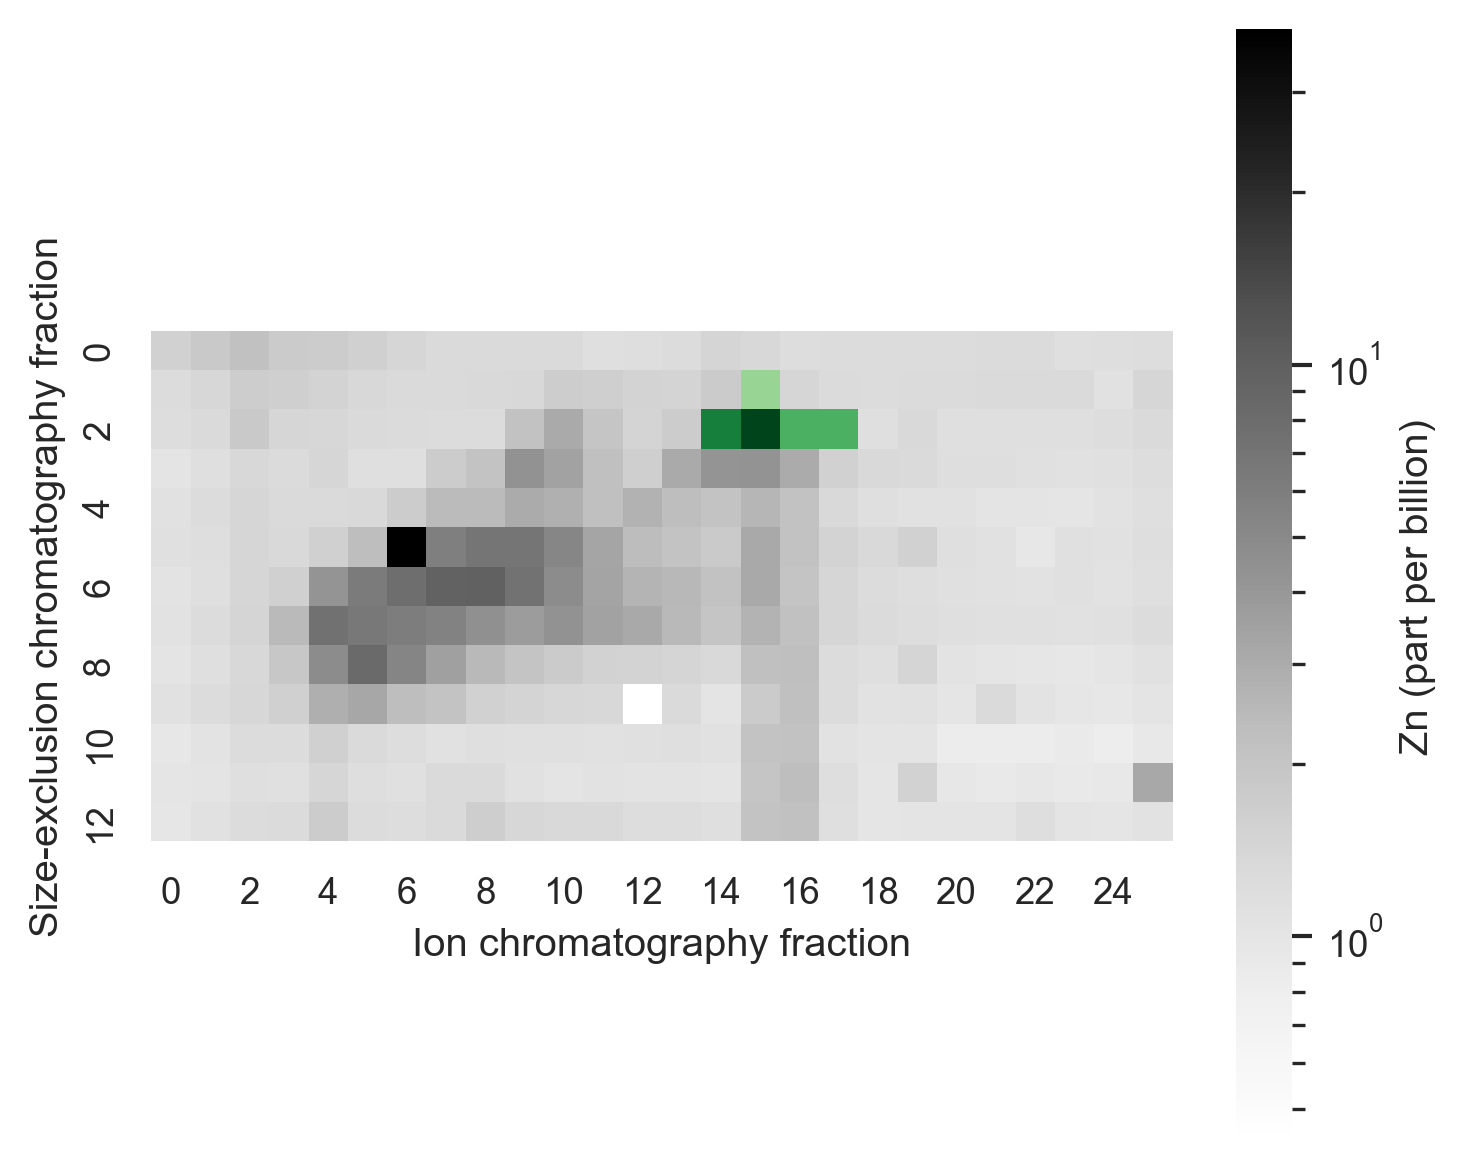

In [22]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(5, 4))

# heatmap of 56Fe data against x and y
sns.heatmap(metal_join_df.pivot("56Fe", "x", "y", )[:, 1:], cmap="Grays", square=True, cbar=True, norm=LogNorm(), cbar_kws={'label': 'Zn (part per billion)'})
sns.heatmap(prot_df.pivot("rpmE", "x", "y", )[:, 1:], mask=(prot_df.pivot("rpmE", "x", "y", ) < 1).to_numpy()[:, 1:],
            cmap="Greens", square=True, cbar=False, vmin=0,  cbar_kws={'label': 'RpmE (spectral count)'})

# change x and y axis labels
plt.ylabel("Size-exclusion chromatography fraction")
plt.xlabel("Ion chromatography fraction")

# plt.xlim([0, 27])
# plt.ylim([13,0])

plt.tight_layout()

# save as png and svg
# plt.savefig("figures/zn_rpme.png")
# plt.savefig("figures/zn_rpme.svg")


# Check out some data

In [23]:
prot_df.filter((pl.col("y") == 7) & (pl.col("x") == 13)).melt(id_vars=["Experiment", "x", "y"], variable_name="Gene", value_name="Intensity")

Experiment,x,y,Gene,Intensity
str,i64,i64,str,i64
"""600to650_8""",13,7,"""tufB""",44
"""600to650_8""",13,7,"""rplC""",8
"""600to650_8""",13,7,"""rpsE""",18
"""600to650_8""",13,7,"""fliC""",37
"""600to650_8""",13,7,"""groL""",55
…,…,…,…,…
"""600to650_8""",13,7,"""ygaC""",0
"""600to650_8""",13,7,"""ycaK""",0
"""600to650_8""",13,7,"""miaA""",0


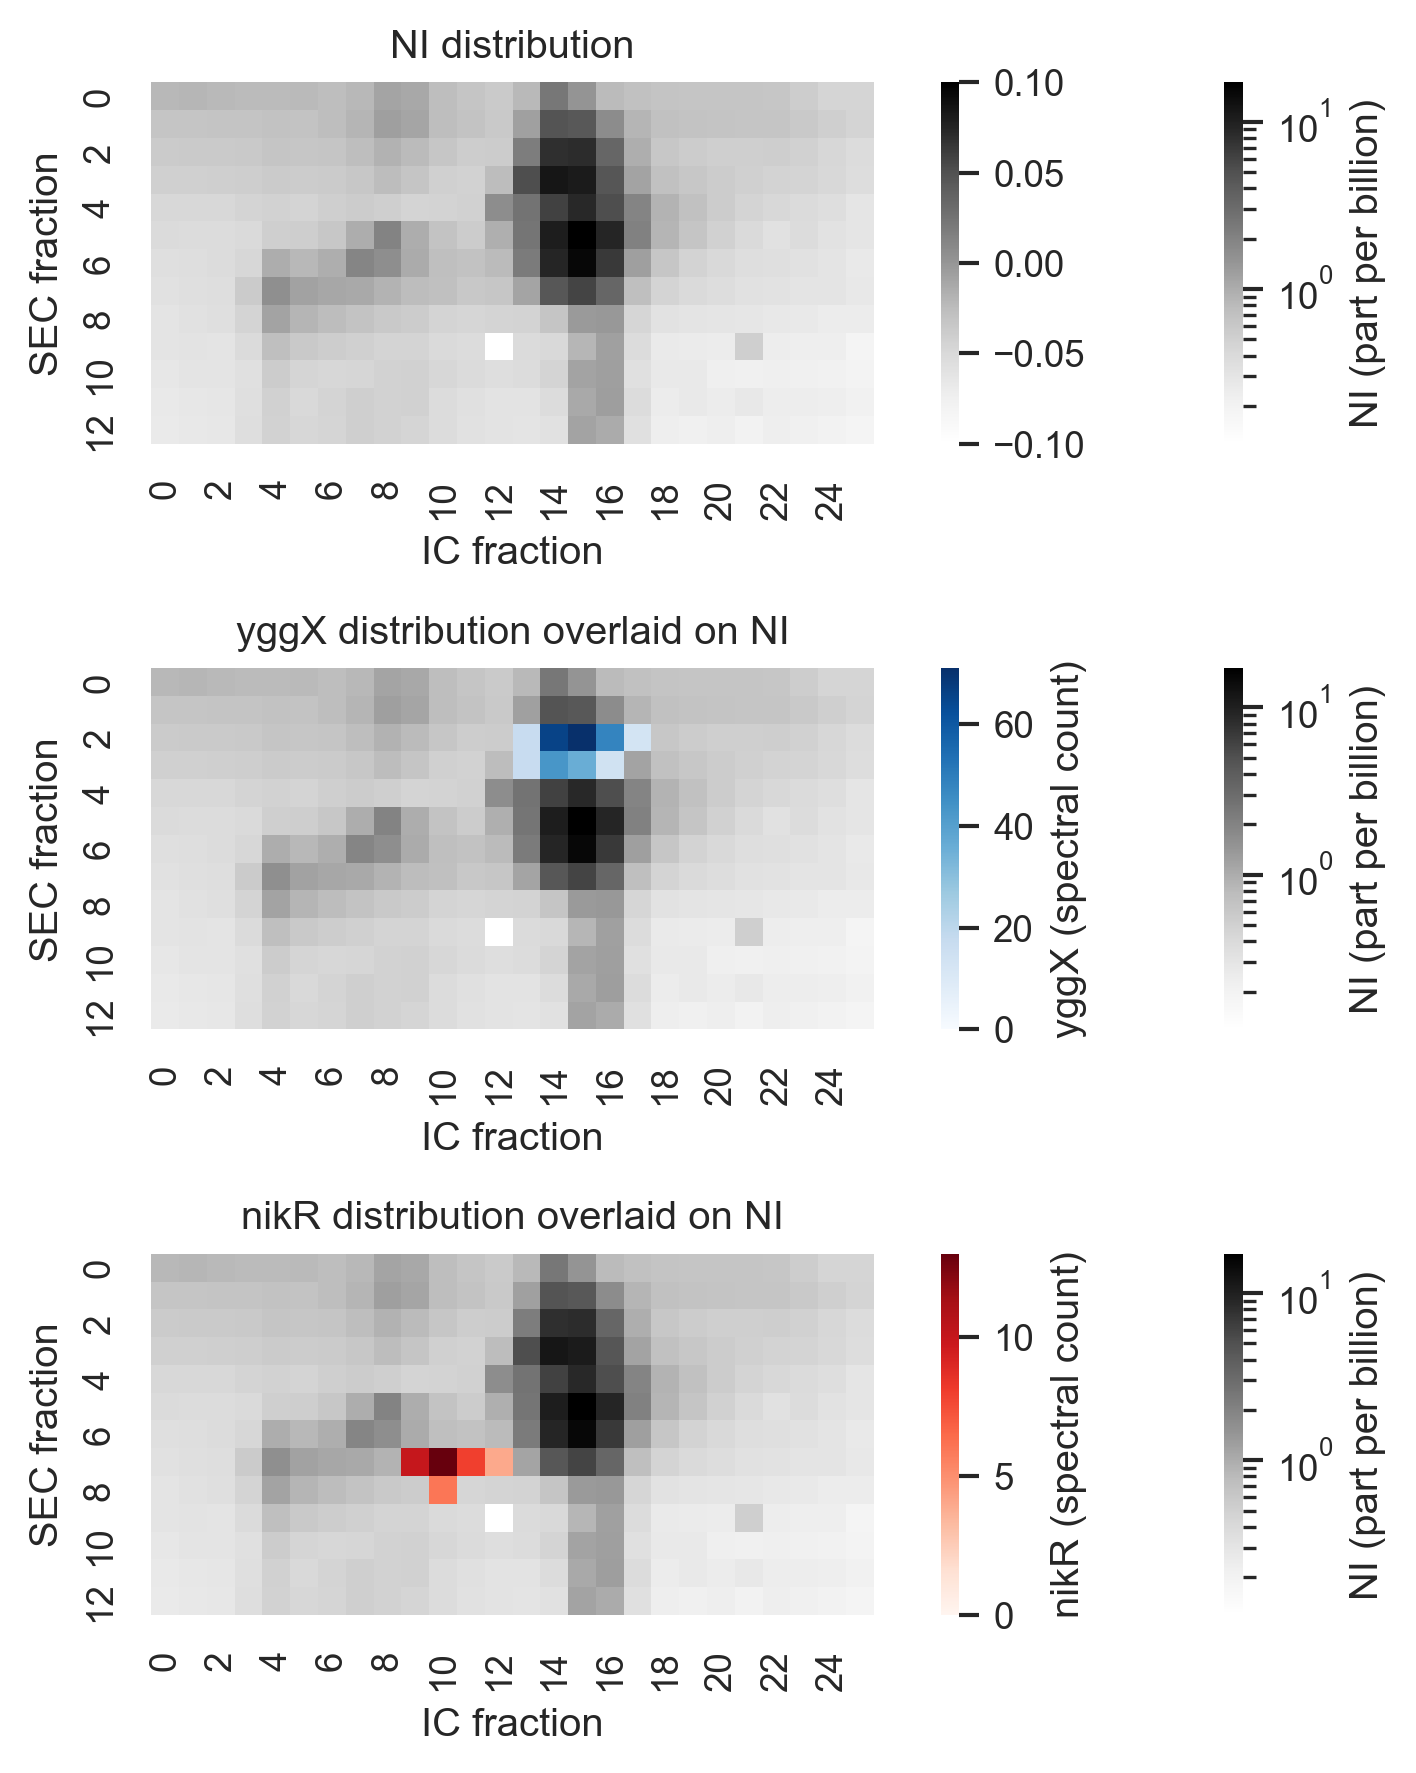

In [24]:
from matplotlib.colors import LogNorm
# plt.figure(figsize=(12, 6))

f, ax = plt.subplots(3,1, figsize=(6, 6))

gene = "yggX"
gene2 = "nikR"
metal = "60Ni"
metal_translated = isotope_element_mapping[metal]

# heatmap of 56Fe data against x and y
sns.heatmap(metal_join_df.pivot(metal, "x", "y", )[:, 1:], cmap="Grays", square=True, cbar=True,
            norm=LogNorm(), cbar_kws={'label': f'{metal_translated} (part per billion)'}, ax=ax[0])
sns.heatmap(prot_df.pivot(gene, "x", "y", )[:, 1:], mask=(prot_df.pivot(gene, "x", "y", ) < 1000).to_numpy()[:, 1:],
            cmap="Grays", square=True, cbar=True, vmin=0,  cbar_kws={'label': f' '}, ax=ax[0])

# add x and y labels
ax[0].set_ylabel("SEC fraction")
ax[0].set_xlabel("IC fraction")


sns.heatmap(metal_join_df.pivot(metal, "x", "y", )[:, 1:], cmap="Grays", square=True,
            cbar=True, norm=LogNorm(), cbar_kws={'label': f'{metal_translated} (part per billion)'}, ax=ax[1])
sns.heatmap(prot_df.pivot(gene, "x", "y", )[:, 1:], mask=(prot_df.pivot(gene, "x", "y", ) < 1).to_numpy()[:, 1:],
            cmap="Blues", square=True, cbar=True, vmin=0,  cbar_kws={'label': f'{gene} (spectral count)'}, ax=ax[1])

# add x and y labels
ax[1].set_ylabel("SEC fraction")
ax[1].set_xlabel("IC fraction")

sns.heatmap(metal_join_df.pivot(metal, "x", "y", )[:, 1:], cmap="Grays", square=True,
            cbar=True, norm=LogNorm(), cbar_kws={'label': f'{metal_translated} (part per billion)'}, ax=ax[2])
sns.heatmap(prot_df.pivot(gene2, "x", "y", )[:, 1:], mask=(prot_df.pivot(gene2, "x", "y", ) < 1).to_numpy()[:, 1:],
            cmap="Reds", square=True, cbar=True, vmin=0,  cbar_kws={'label': f'{gene2} (spectral count)'}, ax=ax[2])

# add x and y labels
ax[2].set_ylabel("SEC fraction")
ax[2].set_xlabel("IC fraction")

# add subplot titles
ax[0].set_title(f"{metal_translated} distribution")
ax[1].set_title(f"{gene} distribution overlaid on {metal_translated}")
ax[2].set_title(f"{gene2} distribution overlaid on {metal_translated}")

plt.tight_layout()

# save as png and svg
plt.savefig("figures/cu.png")
# plt.savefig("figures/zn_bare.svg")


# Where's most proteins found

Text(0.5, 1.0, 'Protein metE distribution overlaid on sum of spectral counts')

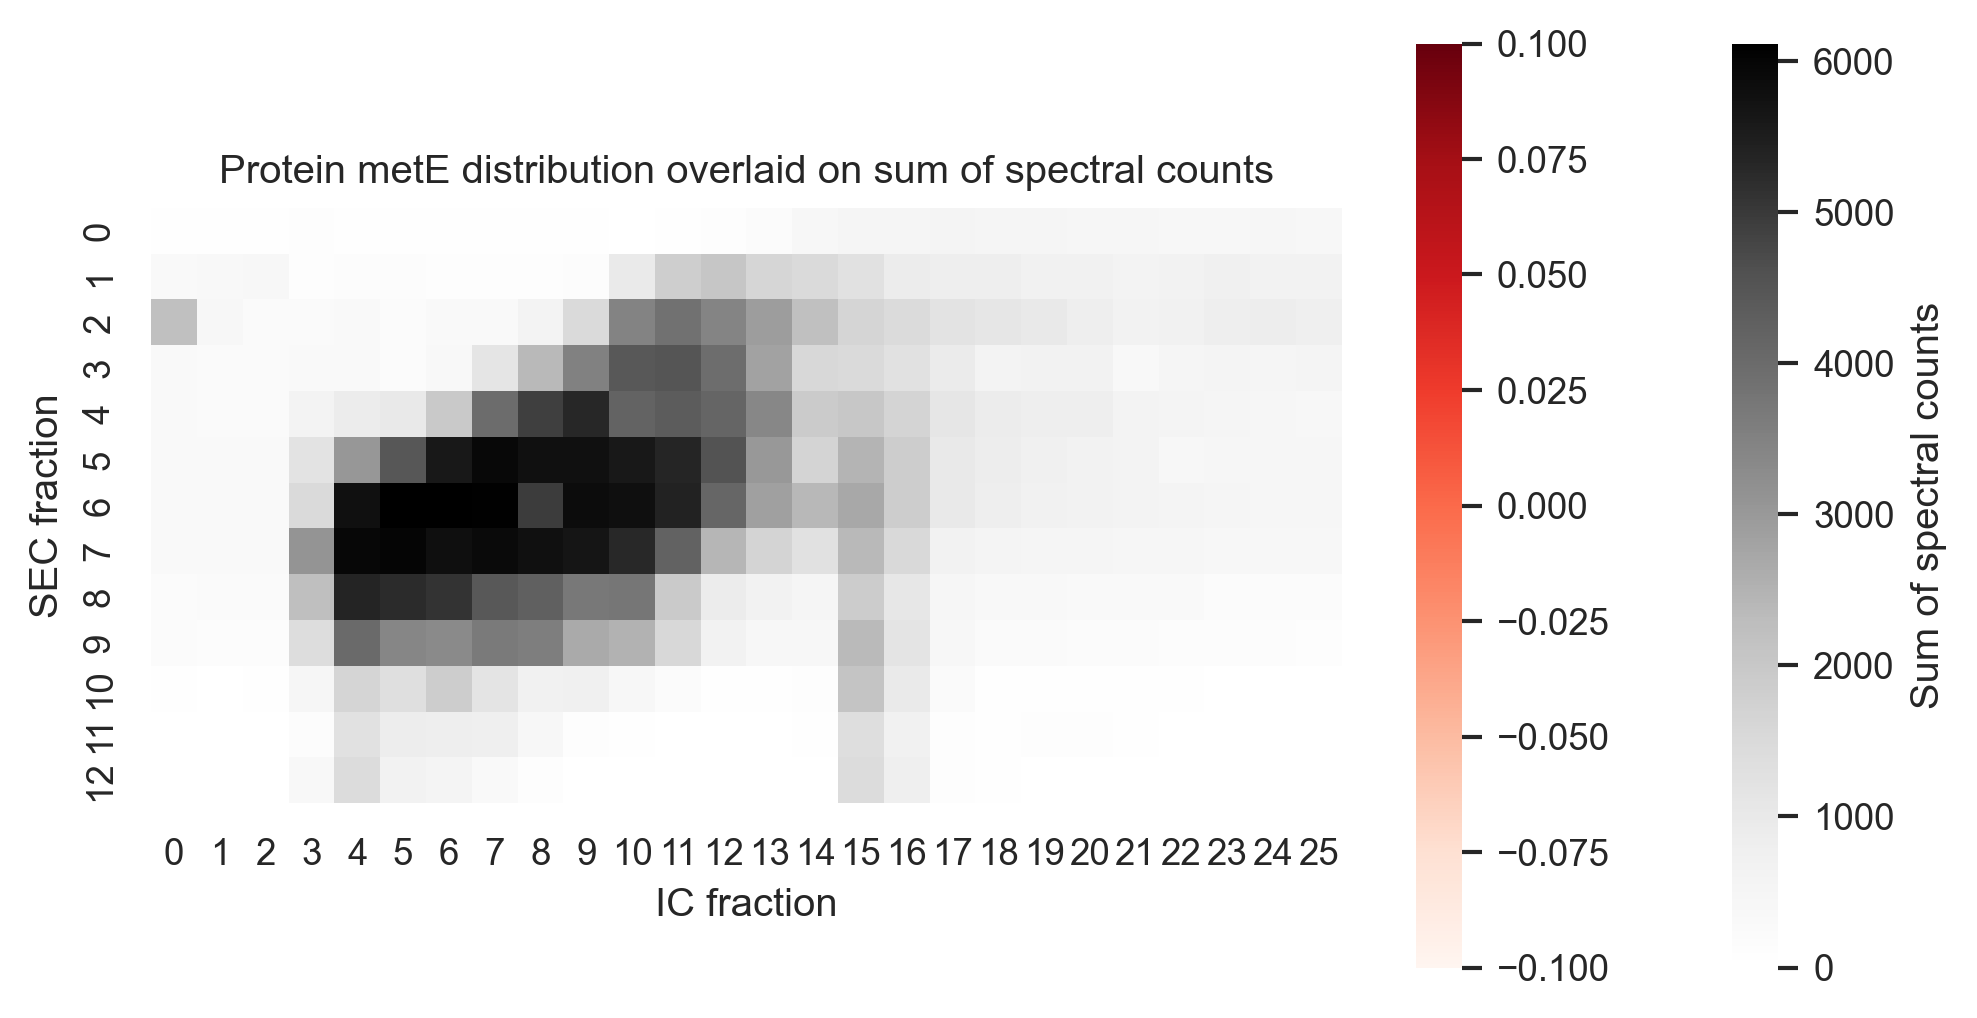

In [25]:
plt.figure(figsize=(8, 4))

# get the sum of all proteins
prot_sum = prot_df.drop(["Experiment", "x", "y"]).sum(axis=1)

# create new df with x and y cols
prot_sum_df = prot_df.select(["x", "y"]).with_columns(pl.Series(name="Sum", values=prot_sum))

# pivot and heatmap
sns.heatmap(prot_sum_df.pivot("Sum", "x", "y", )[:, 1:], cmap="Grays", square=True, cbar=True, cbar_kws={'label': 'Sum of spectral counts'})

gene = "metE"

# heatmap of 56Fe data against x and y
# sns.heatmap(metal_join_df.pivot(metal, "x", "y", )[:, 1:], cmap="Grays", square=True, cbar=True,
#             norm=LogNorm(), cbar_kws={'label': f'{metal_translated} (part per billion)'}, ax=ax[0])
sns.heatmap(prot_df.pivot(gene, "x", "y", )[:, 1:], mask=(prot_df.pivot(gene, "x", "y", ) < 1000).to_numpy()[:, 1:],
            cmap="Reds", square=True, cbar=True, vmin=0,  cbar_kws={'label': f' '})

# set x and y labels
plt.ylabel("SEC fraction")
plt.xlabel("IC fraction")

# set title
plt.title(f"Protein {gene} distribution overlaid on sum of spectral counts")

# Identify protein responsible for unknown peak

In [26]:
description_df = prot_df_raw.select(["Identified Proteins (1235)", "Accession Number"])

description_df = gene_df.join(description_df, on="Accession Number")

# rename Identified Proteins (1235) to "Description"
description_df = description_df.rename({"Identified Proteins (1235)": "Description", "Gene Name": "Gene"})

# Add new column, "is unknown function", 
description_df = description_df.with_columns(pl.Series(name="is unknown function", values=[1 if desc.startswith("y") else 0 for desc in description_df["Gene"]]))

description_df.filter(pl.col("is unknown function") == 1)

Accession Number,Gene,Description,is unknown function
str,str,str,i64
"""AAC74534.1""","""yncE""","""ATP-binding protein, periplasm…",1
"""AAC74287.1""","""ychF""","""catalase inhibitor protein; AT…",1
"""AAC74934.1""","""yebC""","""UPF0082 family protein [Escher…",1
"""AAC74850.2""","""yeaD""","""D-hexose-6-phosphate epimerase…",1
"""AAC76668.1""","""yicC""","""UPF0701 family protein [Escher…",1
…,…,…,…
"""AAC74609.1""","""ydeI""","""hydrogen peroxide resistance O…",1
"""AAC74504.2""","""ydcI""","""putative DNA-binding transcrip…",1
"""AAC74995.1""","""yedD""","""lipoprotein [Escherichia coli …",1


# Pre

In [27]:
# pivot mn df
metal_join_df.pivot("55Mn", "x", "y", )[:, 1:]


1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.994977,0.965916,0.947359,0.926318,0.90726,0.877762,0.822101,0.765879,0.751352,0.726608,0.689698,0.69872,0.676335,0.675708,0.663571,0.470064,0.559456,0.641848,0.638831,0.659044,0.688471,0.671588,0.649676,0.508221,0.340396,0.270356
0.58979,0.575637,0.604288,0.60819,0.58979,0.58084,0.586234,0.593922,0.605971,0.907338,5.555798,3.588784,1.522298,0.802878,0.688561,0.634393,0.633016,0.560107,0.563627,0.568485,0.572348,0.577971,0.561141,0.499254,0.323753,0.240318
0.459015,0.456777,0.450097,0.434769,0.445078,0.441212,0.442094,0.434702,0.472512,2.476535,8.327396,3.652099,1.498314,0.758948,0.792297,0.822932,0.681774,0.450402,0.419713,0.401335,0.384584,0.375226,0.386992,0.349999,0.251475,0.170285
0.366247,0.349785,0.35525,0.365872,0.366487,0.35665,0.349717,0.347565,0.39849,0.980649,0.981025,0.647693,0.474455,1.0109,1.817966,1.932914,1.050553,0.434216,0.357709,0.316726,0.297601,0.292717,0.27916,0.263451,0.200141,0.135128
0.299965,0.297138,0.300832,0.300756,0.314063,0.329858,0.378412,0.364991,0.453173,0.513838,0.555276,0.487708,0.429345,0.531257,0.545549,0.793993,0.847554,0.386103,0.310218,0.281004,0.282587,0.251188,0.249756,0.242933,0.202226,0.126094
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.22402,0.233469,0.238113,0.250641,0.342066,0.52699,0.978884,0.829982,0.486643,0.324191,0.259929,0.241569,0.245619,0.238059,0.249777,0.929663,1.374411,0.353299,0.219916,0.202366,0.172074,0.165055,0.165055,0.166404,0.151772,0.102799
0.205029,0.210807,0.211487,0.213131,0.240157,0.287298,0.31274,0.27353,0.233867,0.211261,0.208315,0.210184,0.058973,0.201799,0.170921,0.706054,1.258452,0.307243,0.188824,0.15721,0.134435,0.324255,0.144859,0.14248,0.132055,0.08322
0.176442,0.180501,0.1767,0.173801,0.192999,0.197895,0.183336,0.155763,0.182563,0.16781,0.191066,0.180565,0.178375,0.196736,0.190744,0.937601,1.294088,0.275592,0.180308,0.149128,0.122522,0.12658,0.126129,0.128062,0.113825,0.075882


# Calculate uncertainty

In [28]:
metal_join_df

Experiment,25Mg,26Mg,29Si,31P,34S,44Ca,71Ga,73Ge,27Al,47Ti,48Ti,51V,52Cr,55Mn,56Fe,57Fe,59Co,60Ni,63Cu,66Zn,75As,77Se,95Mo,111Cd,115In,118Sn,121Sb,182W,202Hg,208Pb,209Bi,x,y
str,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
"""100to150_2""",2424,3268,358150,658,10318,10690,4,2,1.28963,0.105418,0.23391,0.20744,0.437886,0.994977,1.57962,1.247038,0.036616,0.831977,0.229864,0.30864,0.014489,0.200652,0.081377,0.001336,-13.40308,0.038449,0.004793,12.471815,2.004132,0.00593,4.187315,3,1
"""100to150_3""",2404,3293,353562,737,11082,10791,7,4,1.434155,0.086251,0.26326,0.189714,0.449281,0.965916,1.851357,1.489283,0.035843,0.854022,0.242732,0.302458,0.015648,0.183931,0.081209,0.000779,-13.505967,0.040625,0.005548,12.224868,2.077455,0.006276,3.513492,3,2
"""100to150_4""",2298,3197,346458,704,10499,10289,4,4,1.605376,0.103501,0.246314,0.187535,0.473168,0.947359,2.152927,1.808355,0.035271,0.819974,0.256623,0.304706,0.024341,0.16721,0.077411,0.001781,-13.331345,0.040189,0.005903,12.101366,2.321863,0.006496,3.248776,3,3
"""100to150_5""",2420,3155,341925,690,9885,10242,1,3,1.478341,0.093918,0.238977,0.168423,0.434999,0.926318,1.782944,1.457018,0.03481,0.787764,0.273798,0.312854,0.017386,0.066884,0.079091,0.000668,-13.197517,0.038805,0.005015,13.95364,2.24854,0.006416,3.561624,3,4
"""100to150_6""",2276,3048,329445,753,10192,10398,2,1,1.46177,0.113085,0.252254,0.170305,0.443807,0.90726,1.764867,1.436532,0.036868,0.797316,0.261809,0.34882,0.016227,0.183931,0.078738,0.001002,-13.089512,0.034137,0.004616,12.348343,2.224101,0.00667,3.3691,3,5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""700to800_23""",687,1066,62194,282,3446,4018,0,1,0.968749,0.067557,0.266934,0.100142,0.235307,0.12268,1.015955,0.727855,0.008304,0.205888,0.172192,0.322502,0.021042,0.265612,0.074713,0.000638,-14.964736,0.022933,0.00529,20.51376,1.913082,0.004284,5.048914,15,22
"""700to800_24""",1032,1291,63460,280,3725,5395,1,1,2.75897,0.117098,0.31536,0.101578,0.232665,0.127879,1.182385,0.9304,0.009572,0.23914,0.192601,0.541271,0.017096,0.265612,0.091301,0.000638,-15.408186,0.083402,0.005208,19.536919,1.647375,0.005147,9.42467,15,23
"""700to800_25""",576,809,65263,326,3752,3352,1,1,1.023242,0.076564,0.206102,0.107803,0.262816,0.119358,1.022619,0.776596,0.008429,0.220881,0.171453,0.253877,0.015781,0.132806,0.076556,0.001064,-15.137232,0.026768,0.004394,14.327084,1.753658,0.004305,4.039135,15,24


<Axes: ylabel='Count'>

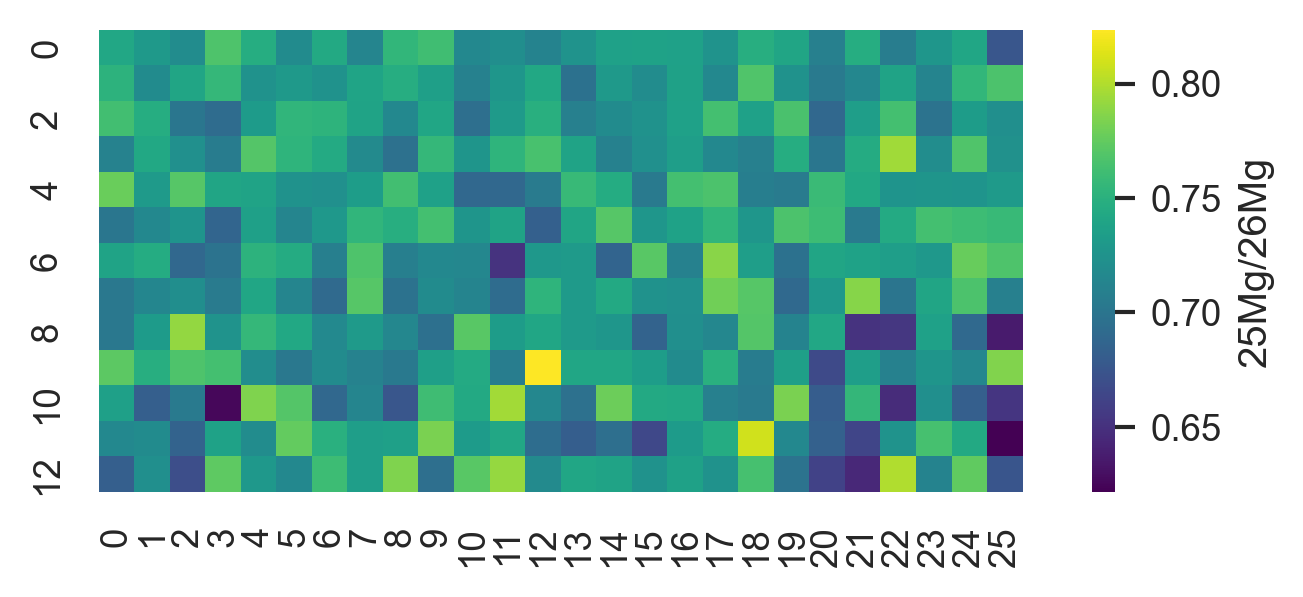

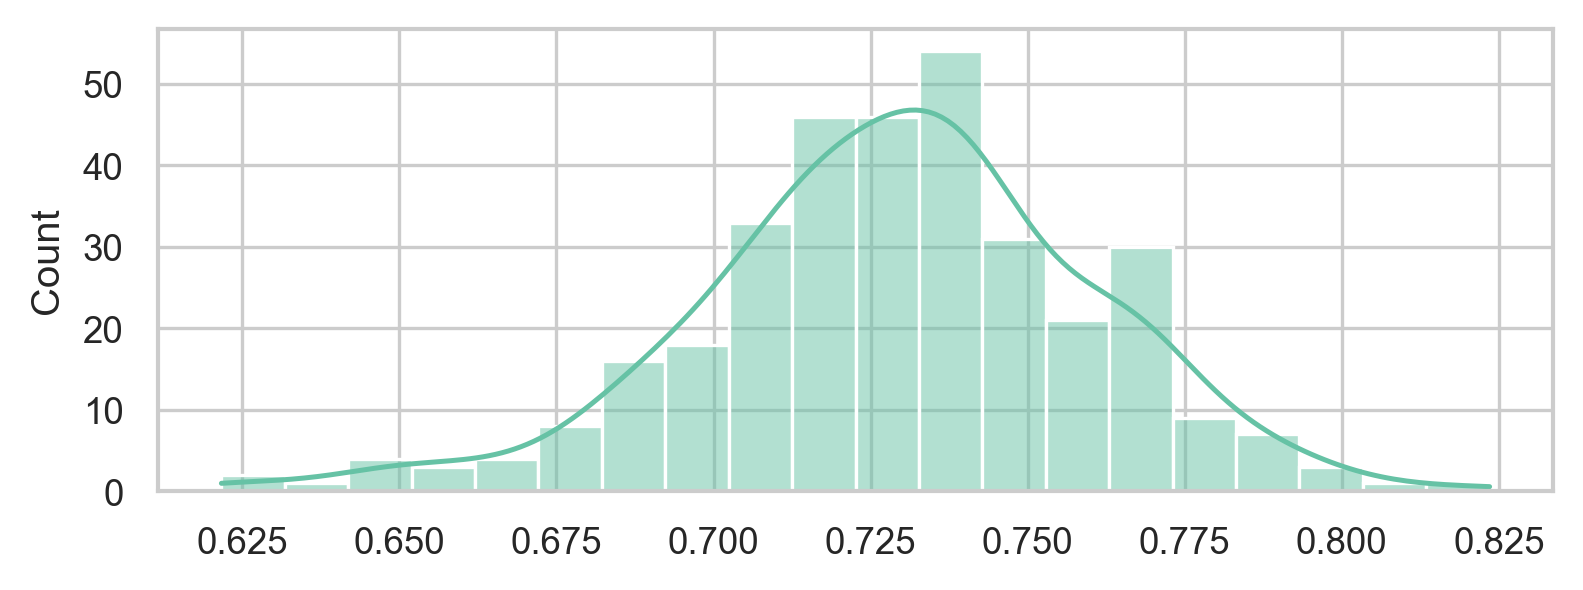

In [29]:
# get 56Fe and 57Fe 

Fe56 = metal_join_df.pivot("25Mg", "x", "y", )[:, 1:].to_numpy()
Fe57 = metal_join_df.pivot("26Mg", "x", "y", )[:, 1:].to_numpy()

# calculate the uncertainty
Fe_uncertainty = Fe56 / Fe57

# plot
plt.figure(figsize=(6, 2))
sns.heatmap(Fe_uncertainty, cmap="viridis", square=True, cbar=True, cbar_kws={'label': '25Mg/26Mg'})

# make a hist of the values
plt.figure(figsize=(6, 2))
sns.histplot(Fe_uncertainty.flatten(), bins=20, kde=True)


(0.625, 0.825)

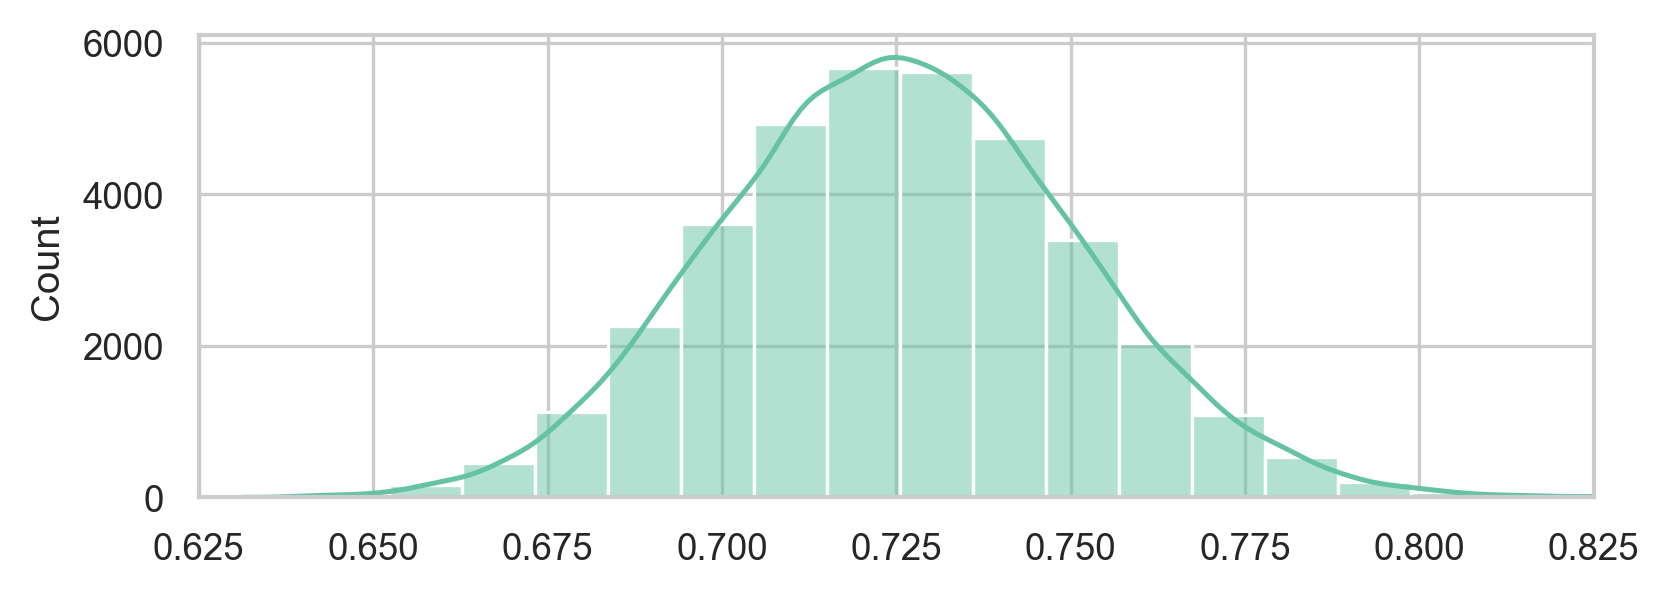

In [30]:
# simulate the ratio of two random numbers. 
n_samples = 36000
Fe56 = np.random.normal(0.725, 0.025*0.725, n_samples)
Fe57 = np.random.normal(1, 0.025, n_samples)

ratio = Fe56 * np.reciprocal(Fe57)

plt.figure(figsize=(6, 2))
sns.histplot(ratio.flatten(), bins=20, kde=True)
plt.xlim(0.625, 0.825)

# Matrix/optimization approach.

In [31]:

# compute the timeseries for the elements
PE = P @ E[:, element_indices]

# get the PE matrix for the detected proteins
PE_detected = PE[detected_protein_idx, :]

PE_detected

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 137 stored elements and shape (1228, 6)>

In [32]:
cur_metal = "ZN"

# find complexes with metal
cplx_has_metal = sim_prot_metal_df.group_by("Complex ID").agg(pl.sum(cur_metal))

# rename metal col to "Complex has metal"
cplx_has_metal = cplx_has_metal.rename({cur_metal: "Complex has metal"})

# convert to boolean
cplx_has_metal = cplx_has_metal.with_columns(pl.Series(name="Complex has metal", values=cplx_has_metal["Complex has metal"] > 0))

# join
sim_metal_spec = sim_prot_metal_df.join(cplx_has_metal, on="Complex ID")

# filter to only include detected proteins
sim_metal_spec = sim_metal_spec.filter(pl.col("Protein ID").is_in(detected_protein_ids))

sim_metal_spec

FE,ZN,MN,CU,MO,NI,Protein ID,Gene,Complex ID,Complex has metal
f64,f64,f64,f64,f64,f64,str,str,str,bool
0.0,0.0,0.0,0.0,0.0,0.0,"""1-PFK-MONOMER""","""fruK""","""1-PFK""",false
0.0,0.0,0.0,0.0,0.0,0.0,"""2-ISOPROPYLMALATESYN-MONOMER""","""leuA""","""2-ISOPROPYLMALATESYN-MONOMER""",false
0.0,0.0,0.0,0.0,0.0,0.0,"""2-OCTAPRENYL-METHOXY-BENZOQ-ME…","""ubiE""","""CPLX0-8301""",false
0.0,0.0,0.0,0.0,0.0,0.0,"""3-CH3-2-OXOBUTANOATE-OH-CH3-XF…","""panB""","""3-METHYL-2-OXOBUT-OHCH3XFER-CP…",false
0.0,0.0,0.0,0.0,0.0,0.0,"""3-ISOPROPYLMALDEHYDROG-MONOMER""","""leuB""","""3-ISOPROPYLMALDEHYDROG-CPLX""",false
…,…,…,…,…,…,…,…,…,…
0.0,0.0,0.0,0.0,0.0,0.0,"""YJJK-MONOMER""","""ettA""","""YJJK-MONOMER""",false
0.0,0.0,0.0,0.0,0.0,0.0,"""YLIB-MONOMER""","""gsiB""","""ABC-49-CPLX""",false
0.0,0.0,0.0,0.0,0.0,0.0,"""YNEA-MONOMER""","""lsrB""","""ABC-58-CPLX""",false


In [33]:
prof_df_gene_order = prot_df.drop(["Experiment", "x", "y"]).columns

# only pick out the genes that are in the gene_indices
prot_df_gene_order = [gene for gene in prof_df_gene_order if gene in gene_to_prot_dict]

M = prot_df.drop(["Experiment", "x", "y"]).to_numpy()[:, gene_indices]

# for each gene in prot_df_gene_order, pick out the corresponding index in sim_metal_spec
# and get the "Complex has metal" value
m_filter = np.zeros(len(detected_protein_ids))

for i, gene in enumerate(prot_df_gene_order):
    if gene in sim_metal_spec["Gene"]:
        m_filter[i] = sim_metal_spec.filter(pl.col("Gene") == gene).select("Complex has metal").to_numpy()[0,0]

m_filter

array([0., 1., 1., ..., 0., 0., 0.])

In [34]:
# n_well x n_prot matrix of normalized intensities
# n_well x 1 vector of metal masses 
# n_prot x 1 vector of protein counts (variable) times per protein stoichiometry

M = prot_df.drop(["Experiment", "x", "y"]).to_numpy()[:, gene_indices]

gene_names_filtered = np.array(gene_names)[gene_indices].tolist()

# set dtype to float64
M = M.astype(np.float64)

# change nans to 0
M[np.isnan(M)] = 0

# normalize the matrix so each col sums to 1
col_sums = M.sum(axis=0)
M = M / col_sums

# change nans to 0
M[np.isnan(M)] = 0

# get indices where M times a 1 vector is nonzero
metal_present_in_well = M @ m_filter > 0

# get the Zn vector
m_vec = metal_join_df[element_isotope_mapping[cur_metal]].to_numpy()
m_vec = m_vec.copy()

# zero out the wells where Zn is not present in proteins
m_vec[~metal_present_in_well] = 0

# normalize m_vec
m_vec = m_vec / m_vec.sum()

# get the filter for proteins that have Zn
element_idx = elements.index(cur_metal)
# m_filter = PE_detected[:, element_idx].toarray().flatten()

In [35]:
# create upper and lower bounds for m_vec that are 0.975 and 1.025 times the original value
m_vec_upper = m_vec * 1.025
m_vec_lower = m_vec * 0.975

In [36]:
n_cplx_filt = sim_metal_spec.unique("Complex ID").shape[0]
cplx_names_mix = sim_metal_spec.unique("Complex ID").select("Complex ID").to_numpy()[:,0].tolist()

# create a monomer to complex matrix for comparing to sim
C_mixed = np.zeros([n_cplx_filt, len(gene_names_filtered)])

# for each gene, find the corresponding complex id in sim_metal_spec
for i, gene in enumerate(gene_names_filtered):
    cplx_id = sim_metal_spec.filter(pl.col("Gene") == gene).select("Complex ID").to_numpy()[0,0]
    cplx_idx = cplx_names_mix.index(cplx_id)
    
    C_mixed[cplx_idx, i] = 1

In [37]:
sim_cplx_met_agg = sim_metal_spec.group_by("Complex ID").agg(pl.sum(cur_metal))

sim_cplx_met_agg.sort(cur_metal)

# create target vec
cplx_agg_vec = np.zeros(n_cplx_filt)



# for each complex, find the corresponding index in sim_metal_spec, set the value to the Zn value
for i, cplx_id in enumerate(cplx_names_mix):
    cplx_agg_vec[i] = sim_cplx_met_agg.filter(pl.col("Complex ID") == cplx_id).select(cur_metal).to_numpy()[0,0]
    

In [38]:
counts = cp.Variable(len(detected_protein_ids))

m_vec_var = cp.Variable(len(m_vec))

# create the constraints
constr = []
constr.append(counts >= 0)
constr.append(m_vec_var >= m_vec_lower)
constr.append(m_vec_var <= m_vec_upper)


obj = cp.norm1( M @ cp.multiply(counts, m_filter) - 1*m_vec_var)  # m_vec_var
obj += 1 * cp.norm2((C_mixed @ counts - cplx_agg_vec)) 
obj += 0.000001 * cp.sum(counts)

prob = cp.Problem(cp.Minimize(obj), constr,)
prob.solve( solver="CLARABEL")

counts_solved = counts.value

In [39]:
np.abs( M @ np.multiply(counts.value, m_filter) - m_vec_var.value).sum()

0.2889384308198859

In [40]:
np.abs( M @ np.multiply(counts.value, m_filter) - m_vec_var.value).sum()

0.2889384308198859

In [41]:
gene_responsible_mass =  (M @ np.diag(np.multiply(counts.value, m_filter))).sum(axis=0)
# note that this will not be 1, since some metal mass is not accounted for because no protein is available. 

# normalize
gene_responsible_mass_norm = gene_responsible_mass / gene_responsible_mass.sum()

In [42]:
# show error in heatmap
error_df = prot_df.select(["x", "y"])
error = m_vec_var.value - M @ np.multiply(counts.value, m_filter)
values = M @ np.multiply(counts.value, m_filter)

error_df = error_df.with_columns(pl.Series(name="Error", values=error))
error_df = error_df.with_columns(pl.Series(name="Values", values=values))

error_df.pivot("Error", "x", "y", )[:, 1:]

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.000272,0.000243,0.000266,0.000254,0.000418,0.000249,0.000437,0.000516,0.00086,0.000711,0.000536,0.000152,0.000225,0.000184,0.000103,-0.000138,-0.00035,-0.000192,-0.000148,-0.00007,0.000113,0.000236,0.000143,-0.000005,-6.0867e-11,0.000054
0.000173,0.000142,0.000148,0.000293,0.000288,0.000289,0.000268,0.000514,0.000921,0.000859,0.000388,0.000174,-0.00053,0.000018,-0.001038,-0.001384,-0.000329,-0.000163,-0.000189,-0.000084,-0.000091,-0.000043,-0.000106,-0.000159,-0.000138,-0.000152
0.000202,0.000106,0.000106,0.000176,0.00029,0.00036,0.000175,0.000466,0.000566,-1.7821e-11,0.000479,1.9172e-11,3.4968e-15,-1.3996e-12,4.2333e-10,0.00372,-0.000014,-0.000712,-0.000118,-0.000072,-0.000043,0.000025,-0.000123,-0.000075,-0.000272,-0.000067
-0.000054,0.000037,0.000048,0.000018,0.0002,0.000252,0.000249,0.00049,7.2533e-12,-1.0709e-10,0.001065,7.9543e-13,0.000781,0.017203,0.043796,0.043864,0.014788,0.002928,0.001394,0.000981,0.000661,0.000845,0.000426,0.000389,0.000192,-0.00001
0.00026,0.000312,0.000345,0.000272,0.000317,0.000042,3.2656e-12,6.8173e-13,-2.2624e-10,0.000464,0.002768,0.002261,0.00011,-4.0254e-15,0.002227,0.0025,0.001969,0.000379,0.000126,-3.0325e-15,0.000395,-0.000087,1.9895e-16,0.000102,0.000244,0.00003
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.000085,0.000061,0.00025,-0.000299,-0.000087,0.00107,1.4632e-10,0.000161,-0.000949,-0.000226,-0.000058,0.000154,0.000302,0.000329,0.000289,0.00006,0.000381,0.000136,0.00005,0.000068,1.8102e-15,-0.000052,0.000005,0.000075,0.000037,1.6495e-15
0.000186,0.000204,0.000243,8.0473e-13,-0.001437,-0.001168,-0.001559,-0.001168,-0.001977,-2.5067e-16,0.000012,0.000349,-0.000288,0.00029,0.000403,-0.000203,0.000225,0.000085,0.000061,0.000069,0.000086,0.000368,0.000072,0.000043,0.000029,0.000103
0.000256,0.000253,0.000235,0.000258,0.000149,0.000169,-0.000637,0.000058,0.000704,0.000566,0.000574,0.000474,0.000366,0.000506,0.000361,2.4239e-11,0.000148,-0.00003,0.000175,0.00014,0.000045,0.000133,0.00011,0.000579,0.000134,0.000106


In [43]:
error_df.pivot("Values", "x", "y", )[:, 1:]


1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.000234,0.000253,0.000234,0.000258,0.000154,0.000253,0.000096,0.000096,0.000115,0.000209,0.000134,0.000266,0.000173,0.000258,0.000406,0.000555,0.000777,0.000672,0.000574,0.0005,0.000402,0.000272,0.000346,0.000396,0.000365,0.000302
0.000327,0.000358,0.000382,0.000201,0.000308,0.000258,0.000308,0.000239,0.000239,0.000234,0.000314,0.000439,0.00121,0.000966,0.002825,0.002361,0.000925,0.00072,0.000731,0.000646,0.000629,0.000619,0.000685,0.000718,0.000728,0.000698
0.000281,0.000419,0.000407,0.000451,0.000438,0.0003,0.000507,0.000363,0.000521,0.001241,0.001051,0.001189,0.002605,0.005032,0.008949,0.002931,0.002444,0.001889,0.001077,0.000955,0.000789,0.00069,0.000814,0.000764,0.000897,0.000783
0.000581,0.000512,0.000537,0.000606,0.000625,0.000443,0.000507,0.000425,0.001351,0.002371,0.001277,0.002886,0.003273,0.002349,0.001604,0.001599,0.001411,0.00124,0.001075,0.001003,0.000926,0.000675,0.000897,0.00083,0.000786,0.000835
0.000543,0.000537,0.000543,0.000621,0.00076,0.001041,0.001571,0.003287,0.005574,0.005578,0.003349,0.004061,0.004308,0.004711,0.001989,0.001799,0.001099,0.000952,0.000909,0.000992,0.000747,0.001006,0.000951,0.000835,0.000767,0.00086
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.000446,0.000479,0.00038,0.001766,0.006913,0.007047,0.006496,0.004908,0.005528,0.003717,0.002677,0.00139,0.000885,0.000607,0.000547,0.001326,0.000925,0.000506,0.000556,0.00042,0.000496,0.000535,0.000447,0.000396,0.000412,0.000449
0.000333,0.000356,0.000308,0.000915,0.004422,0.004267,0.004098,0.003365,0.003769,0.002055,0.001515,0.00069,0.000578,0.000401,0.000489,0.001245,0.000866,0.000449,0.000405,0.000349,0.000303,0.000473,0.000381,0.000383,0.000368,0.000297
0.000253,0.000244,0.000252,0.000397,0.001445,0.001114,0.001997,0.001218,0.000638,0.000565,0.000452,0.000376,0.000313,0.000222,0.000283,0.00121,0.000852,0.000462,0.000228,0.000267,0.00028,0.000249,0.000271,0.000283,0.00022,0.000265


# Compare to simulation

In [44]:
# create complex assignments
exp_cplx_met_assign = C_mixed @ counts_solved

# normalize by sum
exp_cplx_met_assign = exp_cplx_met_assign  # / exp_cplx_met_assign.sum()

# create a dataframe
exp_cplx_met_df = pl.DataFrame(exp_cplx_met_assign, schema=["Mass"])

# add complex id
exp_cplx_met_df = exp_cplx_met_df.with_columns(pl.Series(name="Complex ID", values=cplx_names_mix))

# join with sim_metal_spec
exp_cplx_met_df = exp_cplx_met_df.join(sim_cplx_met_agg.select(["Complex ID", cur_metal]), on="Complex ID")

# filter out rows where ZN is 0
exp_cplx_met_df = exp_cplx_met_df.filter((pl.col(cur_metal) > 0) & (pl.col("Mass") > 0))

exp_cplx_met_df.to_pandas()

,Mass,Complex ID,ZN
0,3.695445e-04,PORPHOBILSYNTH-CPLX,0.002958
1,6.223970e-04,CPLX0-7801,0.000622
2,4.045844e-02,APORNAP-CPLX,0.041847
3,1.825451e-01,HOMOCYSMET-MONOMER,0.197122
4,1.082300e-10,CPLX0-861,0.001507
5,1.622088e-02,HOMOCYSMETB12-MONOMER,0.001830
6,7.952011e-03,CPLX0-7667,0.001483
7,5.991324e-03,EG10230-MONOMER,0.023125
8,1.623805e-10,CPLX0-7660,0.004845
9,1.403652e-10,MMUM-MONOMER,0.000251


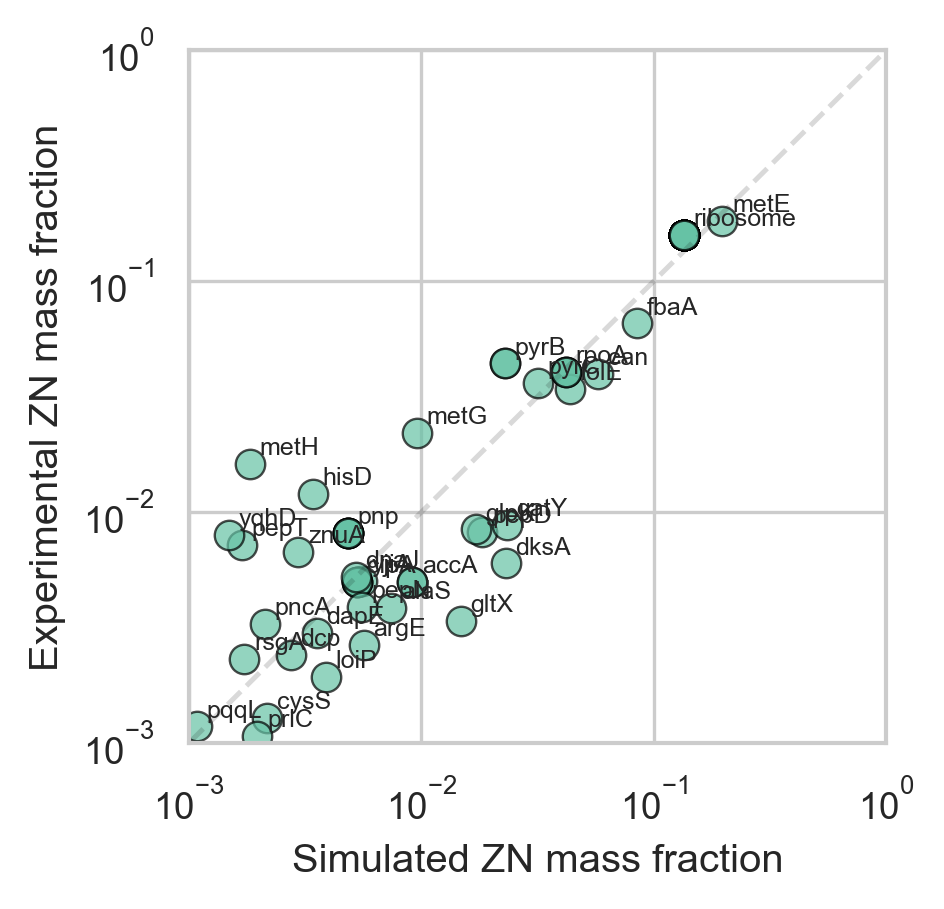

In [45]:
# plot
plt.figure(figsize=(3, 3))

cplx_gene_conversion = sim_metal_spec.select(["Complex ID", "Gene"]) 

# get all genes that have ribosome as cplx
rib_genes = cplx_gene_conversion.filter(pl.col("Complex ID") == "CPLX0-3964").select("Gene").to_numpy()[:,0].tolist()
# create mapping
rib_gene_mapping = {gene: "ribosome" for gene in rib_genes}

# if Complex ID is CPLX0-3964, change gene to ribosome
cplx_gene_conversion = cplx_gene_conversion.with_columns(pl.Series(name="Gene", values=cplx_gene_conversion["Gene"].replace(rib_gene_mapping)))

# join with exp_cplx_met_df
exp_cplx_met_plot_df = exp_cplx_met_df.join(cplx_gene_conversion, on="Complex ID")

sns.scatterplot(x=cur_metal, y="Mass", data=exp_cplx_met_plot_df, alpha=0.7, s=50, edgecolor="black")

# add log scale

plt.xscale("log")
plt.yscale("log")

# limit x and y from 1e-3 to 1e0
plt.xlim([1e-3, 1e-0])
plt.ylim([1e-3, 1e-0])

# change x and y labels
plt.xlabel(f"Simulated {cur_metal} mass fraction")
plt.ylabel(f"Experimental {cur_metal} mass fraction")


cplx_already_added = []
# below each point, plot the name of the protein
for i, txt in enumerate(exp_cplx_met_plot_df["Gene"].to_numpy()):
    cur_cplx = exp_cplx_met_plot_df["Complex ID"].to_numpy()[i]
    
    if cur_cplx not in cplx_already_added:
        plt.annotate(txt, (exp_cplx_met_plot_df[cur_metal].to_numpy()[i] * 1.1, exp_cplx_met_plot_df["Mass"].to_numpy()[i] * 1.1), fontsize=6)
    
    cplx_already_added.append(cur_cplx)
    

# add x=y line
plt.plot([1e-5, 3e-0], [1e-5, 3e-0], color="black", linestyle="--", alpha=0.15)

# save to file
plt.savefig("figures/zn_mass_scatter.png")

In [46]:
exp_cplx_met_plot_df

Mass,Complex ID,ZN,Gene
f64,str,f64,str
0.002659,"""ACETYLORNDEACET-CPLX""",0.005662,"""argE"""
0.00384,"""ALAS-CPLX""",0.007406,"""alaS"""
0.000443,"""AROB-MONOMER""",0.000443,"""aroB"""
0.044011,"""ASPCARBTRANS-CPLX""",0.022898,"""pyrB"""
0.044011,"""ASPCARBTRANS-CPLX""",0.022898,"""pyrI"""
…,…,…,…
0.008806,"""TAGAALDOL2-MONOMER""",0.023271,"""gatY"""
1.8244e-9,"""THIC-MONOMER""",0.00999,"""thiC"""
0.001797,"""THREODEHYD-CPLX""",0.000847,"""tdh"""


# Save to files for TIm

In [47]:
# mkdir
import os
os.makedirs("data/processed_metalloproteome", exist_ok=True)

# save m_vec, C_mixed, M, counts_solved
np.save("data/processed_metalloproteome/zn_target_vec.npy", m_vec)
np.save("data/processed_metalloproteome/protein_to_complex_matrix.npy", C_mixed)
np.save("data/processed_metalloproteome/protein_to_well_matrix.npy", M)
np.save("data/processed_metalloproteome/protein_counts_solved.npy", counts_solved)

# save cplx_names_mix, gene_names_filtered
np.save("data/processed_metalloproteome/complex_names.npy", cplx_names_mix)
np.save("data/processed_metalloproteome/protein_gene_names.npy", gene_names_filtered)

# save x and y
np.save("data/processed_metalloproteome/x_coords.npy", metal_join_df["x"].to_numpy())
np.save("data/processed_metalloproteome/y_coords.npy", metal_join_df["y"].to_numpy())


In [48]:
(C_mixed @ counts_solved)[cplx_names_mix.index("CPLX0-3964")]

0.1581756587764341

# Test a loop 

In [49]:
# try running loop to see how the objective changes
reg_values = np.logspace(-8, 1, 30)

obj_values = np.zeros(len(reg_values))
sim_values = np.zeros(len(reg_values))

for i, reg in enumerate(reg_values):
    obj = cp.norm1( M @ cp.multiply(counts, m_filter) - 1*m_vec_var) 
    obj += reg * cp.norm2(C_mixed @ counts - cplx_agg_vec) 
    obj += 0.000001 * cp.sum(counts)

    prob = cp.Problem(cp.Minimize(obj), constr,)
    prob.solve( solver="CLARABEL")

    obj_values[i] = np.abs( M @ np.multiply(counts.value, m_filter) - 1*m_vec_var.value ).sum()
    sim_values[i] = np.abs( C_mixed @ counts.value - cplx_agg_vec ).sum()

# subtract max from obj_values
obj_values = obj_values - obj_values.min()

obj_values

array([2.19007781e-08, 1.85435751e-08, 2.79783407e-08, 8.00090708e-09,
       3.44209253e-09, 2.26807831e-08, 5.91067512e-09, 1.78817426e-08,
       2.27671511e-08, 9.41562403e-09, 3.06460511e-08, 2.31346010e-08,
       2.66479083e-08, 2.65093273e-08, 3.13200557e-08, 0.00000000e+00,
       2.66192982e-08, 4.53501959e-07, 4.27376980e-07, 5.63783608e-06,
       3.12905122e-05, 2.14319213e-04, 9.23640425e-04, 4.14701257e-03,
       1.12118562e-02, 2.01133850e-02, 5.15084067e-02, 8.91623138e-02,
       1.58738295e-01, 2.37389591e-01])

In [50]:
sim_values

array([9.15734027e-01, 9.20106981e-01, 9.07603526e-01, 9.33559603e-01,
       9.39761547e-01, 9.14691415e-01, 9.37279214e-01, 9.21144671e-01,
       9.14525489e-01, 9.32297667e-01, 9.03813270e-01, 9.13206195e-01,
       9.06653693e-01, 9.04606824e-01, 8.97708705e-01, 9.33536251e-01,
       9.02702776e-01, 9.00140267e-01, 9.21222271e-01, 9.12290137e-01,
       8.95835116e-01, 8.79981169e-01, 8.26862894e-01, 7.15140243e-01,
       5.84566106e-01, 5.07143081e-01, 3.56630219e-01, 2.29607158e-01,
       1.04519382e-01, 2.43790773e-09])

In [51]:
obj_values

array([2.19007781e-08, 1.85435751e-08, 2.79783407e-08, 8.00090708e-09,
       3.44209253e-09, 2.26807831e-08, 5.91067512e-09, 1.78817426e-08,
       2.27671511e-08, 9.41562403e-09, 3.06460511e-08, 2.31346010e-08,
       2.66479083e-08, 2.65093273e-08, 3.13200557e-08, 0.00000000e+00,
       2.66192982e-08, 4.53501959e-07, 4.27376980e-07, 5.63783608e-06,
       3.12905122e-05, 2.14319213e-04, 9.23640425e-04, 4.14701257e-03,
       1.12118562e-02, 2.01133850e-02, 5.15084067e-02, 8.91623138e-02,
       1.58738295e-01, 2.37389591e-01])

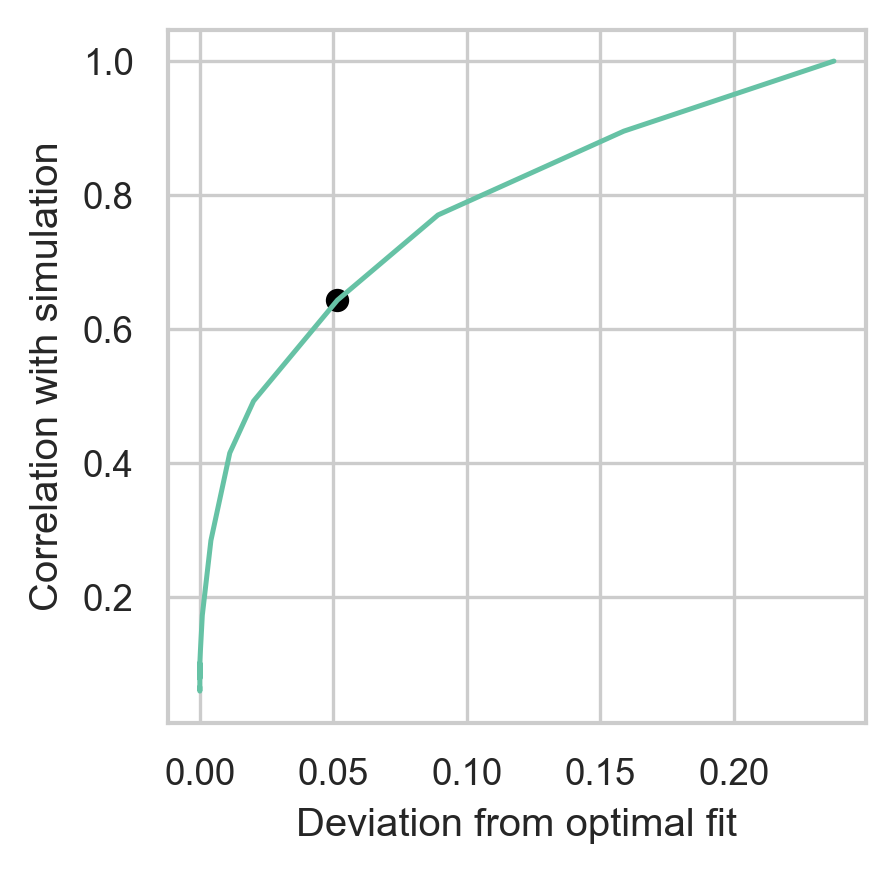

In [52]:
plt.figure(figsize=(3, 3))

# plot the objective values
sns.lineplot(x=obj_values, y=1-sim_values)

# make x go from 0 to 0.6
#plt.xlim([0, 1])

# add axis labels
plt.xlabel("Deviation from optimal fit")
plt.ylabel("Correlation with simulation")

# add a point at third to last value
plt.scatter(obj_values[-4], 1-sim_values[-4], color="black")
# 


# x scale log

# Deconvolution

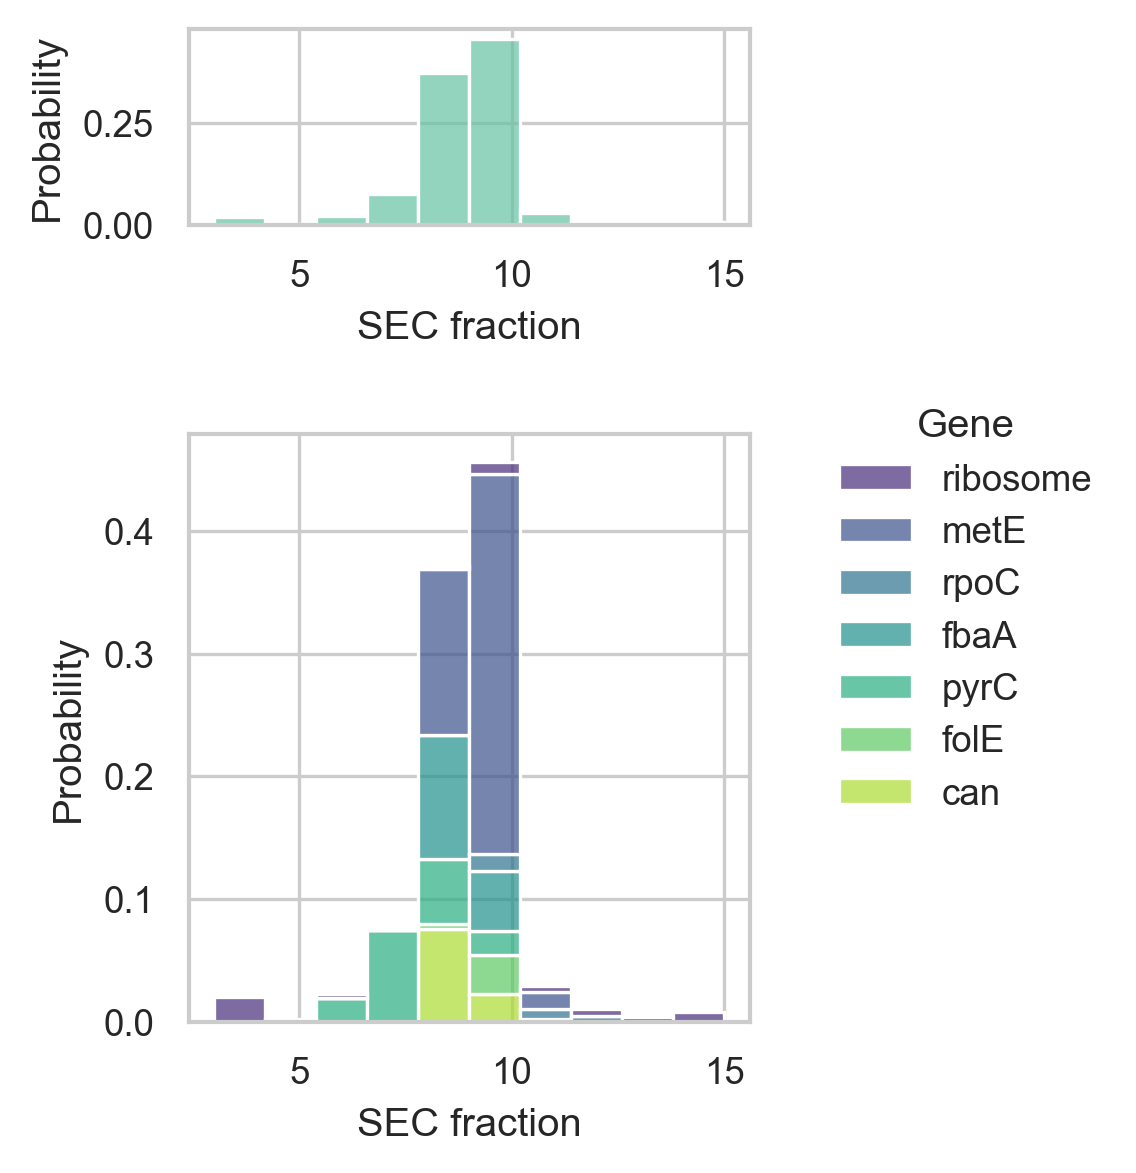

<Figure size 1800x900 with 0 Axes>

In [53]:
f, ax = plt.subplots(2, 1, figsize=(4, 4), gridspec_kw={'height_ratios': [1, 3]})

# get nonzero contribution prots
nonzero_contribution_prots = (M @ np.diag(np.multiply(counts.value, m_filter))).sum(axis=0) > 3*10e-3

# get individual contrib. 
prot_contribution = (M @ np.diag(np.multiply(counts.value, m_filter)))[:, nonzero_contribution_prots] 

prot_contribution_df = pl.DataFrame(prot_contribution, schema=np.array(gene_names_filtered)[nonzero_contribution_prots].tolist())

# add a column for well position 
well_position = np.arange(1, len(prot_contribution_df)+1)
prot_contribution_df = prot_contribution_df.with_columns(pl.Series(name="Well", values=well_position))

# Add columns for x and y
prot_contribution_df = prot_contribution_df.with_columns(pl.Series(name="x", values=metal_join_df["x"].to_numpy()))
prot_contribution_df = prot_contribution_df.with_columns(pl.Series(name="y", values=metal_join_df["y"].to_numpy()))

# melt
prot_contribution_df = prot_contribution_df.melt(variable_name="Gene", value_name="Contribution", id_vars=["Well", "x", "y"])

# select x=11
prot_contribution_df = prot_contribution_df.filter(pl.col("y") == 12)

# aggregate contribution by x
# prot_contribution_df = prot_contribution_df.group_by(["x", "Gene"]).agg(pl.sum("Contribution"))

# if Complex ID is CPLX0-3964, change gene to ribosome
prot_contribution_df = prot_contribution_df.with_columns(pl.Series(name="Gene", values=prot_contribution_df["Gene"].replace(rib_gene_mapping)))

# make kde
# sns.kdeplot(data=prot_contribution_df, x="Well", hue="Gene", fill=True, 
#            multiple="fill", alpha=0.5, weights="Contribution", bw_adjust=1, cut=True, clip=[0, None])

# plot the sums per well
well_sums = prot_contribution_df.group_by("x").agg(pl.sum("Contribution"))

# plot
plt.figure(figsize=(6,3))
sns.histplot(data=well_sums, x="x", weights="Contribution", bins=10,
             alpha=0.7, stat="probability", ax=ax[0])

# try a hist instead
g=sns.histplot(data=prot_contribution_df, x="x", hue="Gene", weights="Contribution", multiple="stack", bins=10,
             alpha=0.7, stat="probability", ax=ax[1], palette="viridis")

# change xlabel
ax[0].set_xlabel("SEC fraction")
ax[1].set_xlabel("SEC fraction")

sns.move_legend(g, "upper left", bbox_to_anchor=(1.1, 1.1), frameon=False)

f.tight_layout()

# save as png
f.savefig("figures/zn_deconvolution.svg", transparent=True)


In [54]:
metal_join_df

Experiment,25Mg,26Mg,29Si,31P,34S,44Ca,71Ga,73Ge,27Al,47Ti,48Ti,51V,52Cr,55Mn,56Fe,57Fe,59Co,60Ni,63Cu,66Zn,75As,77Se,95Mo,111Cd,115In,118Sn,121Sb,182W,202Hg,208Pb,209Bi,x,y
str,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
"""100to150_2""",2424,3268,358150,658,10318,10690,4,2,1.28963,0.105418,0.23391,0.20744,0.437886,0.994977,1.57962,1.247038,0.036616,0.831977,0.229864,0.30864,0.014489,0.200652,0.081377,0.001336,-13.40308,0.038449,0.004793,12.471815,2.004132,0.00593,4.187315,3,1
"""100to150_3""",2404,3293,353562,737,11082,10791,7,4,1.434155,0.086251,0.26326,0.189714,0.449281,0.965916,1.851357,1.489283,0.035843,0.854022,0.242732,0.302458,0.015648,0.183931,0.081209,0.000779,-13.505967,0.040625,0.005548,12.224868,2.077455,0.006276,3.513492,3,2
"""100to150_4""",2298,3197,346458,704,10499,10289,4,4,1.605376,0.103501,0.246314,0.187535,0.473168,0.947359,2.152927,1.808355,0.035271,0.819974,0.256623,0.304706,0.024341,0.16721,0.077411,0.001781,-13.331345,0.040189,0.005903,12.101366,2.321863,0.006496,3.248776,3,3
"""100to150_5""",2420,3155,341925,690,9885,10242,1,3,1.478341,0.093918,0.238977,0.168423,0.434999,0.926318,1.782944,1.457018,0.03481,0.787764,0.273798,0.312854,0.017386,0.066884,0.079091,0.000668,-13.197517,0.038805,0.005015,13.95364,2.24854,0.006416,3.561624,3,4
"""100to150_6""",2276,3048,329445,753,10192,10398,2,1,1.46177,0.113085,0.252254,0.170305,0.443807,0.90726,1.764867,1.436532,0.036868,0.797316,0.261809,0.34882,0.016227,0.183931,0.078738,0.001002,-13.089512,0.034137,0.004616,12.348343,2.224101,0.00667,3.3691,3,5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""700to800_23""",687,1066,62194,282,3446,4018,0,1,0.968749,0.067557,0.266934,0.100142,0.235307,0.12268,1.015955,0.727855,0.008304,0.205888,0.172192,0.322502,0.021042,0.265612,0.074713,0.000638,-14.964736,0.022933,0.00529,20.51376,1.913082,0.004284,5.048914,15,22
"""700to800_24""",1032,1291,63460,280,3725,5395,1,1,2.75897,0.117098,0.31536,0.101578,0.232665,0.127879,1.182385,0.9304,0.009572,0.23914,0.192601,0.541271,0.017096,0.265612,0.091301,0.000638,-15.408186,0.083402,0.005208,19.536919,1.647375,0.005147,9.42467,15,23
"""700to800_25""",576,809,65263,326,3752,3352,1,1,1.023242,0.076564,0.206102,0.107803,0.262816,0.119358,1.022619,0.776596,0.008429,0.220881,0.171453,0.253877,0.015781,0.132806,0.076556,0.001064,-15.137232,0.026768,0.004394,14.327084,1.753658,0.004305,4.039135,15,24


<Axes: >

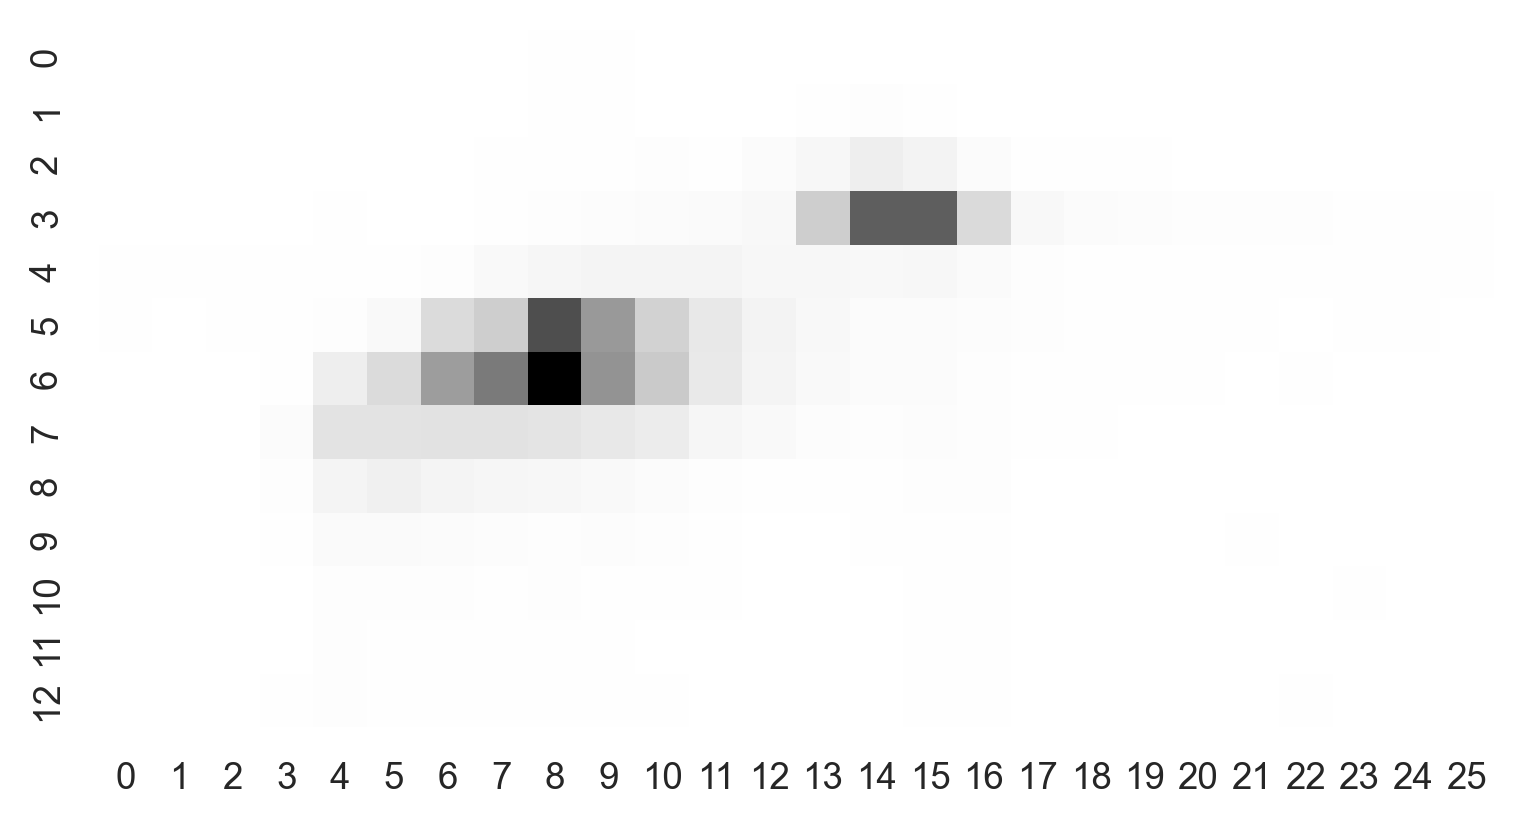

In [55]:
# make heatmap showing selected row
plt.figure(figsize=(6, 4))

# make background zn heatmap with low alpha
sns.heatmap(metal_join_df.pivot("66Zn", "x", "y", )[:, 1:], cmap="Greys", square=True, cbar=False)


# Do all element scatter

In [56]:
prof_df_gene_order = prot_df.drop(["Experiment", "x", "y"]).columns

# only pick out the genes that are in the gene_indices
prot_df_gene_order = [gene for gene in prof_df_gene_order if gene in gene_to_prot_dict]

gene_names_filtered = np.array(gene_names)[gene_indices].tolist()



M = prot_df.drop(["Experiment", "x", "y"]).to_numpy()[:, gene_indices]

# set dtype to float64
M = M.astype(np.float64)

# change nans to 0
M[np.isnan(M)] = 0

# normalize the matrix so each col sums to 1
col_sums = M.sum(axis=0)
M = M / col_sums

# change nans to 0
M[np.isnan(M)] = 0

In [57]:
metal_list = ["FE", "ZN",  "MN",]
all_element_comp_df = None
all_element_data_df = None

lambda_vals = np.logspace(-4, 1, 6)
data_residuals = np.zeros([len(metal_list), len(lambda_vals)])
sim_residuals = np.zeros([len(metal_list), len(lambda_vals)])

for j, cur_metal in enumerate(metal_list):
    # find complexes with metal
    cplx_has_metal = sim_prot_metal_df.group_by("Complex ID").agg(pl.sum(cur_metal))
    cplx_has_metal = cplx_has_metal.rename({cur_metal: "Complex has metal"})
    cplx_has_metal = cplx_has_metal.with_columns(
        pl.Series(name="Complex has metal", values=cplx_has_metal["Complex has metal"] > 0))
    
    sim_metal_spec = sim_prot_metal_df.join(cplx_has_metal, on="Complex ID")
    sim_metal_spec = sim_metal_spec.filter(pl.col("Protein ID").is_in(detected_protein_ids))
    
    n_cplx_filt = sim_metal_spec.unique("Complex ID").shape[0]
    cplx_names_mix = sim_metal_spec.unique("Complex ID").select("Complex ID").to_numpy()[:, 0].tolist()
    
    # create a monomer to complex matrix for comparing to sim
    C_mixed = np.zeros([n_cplx_filt, len(gene_names_filtered)])
    
    # for each gene, find the corresponding complex id in sim_metal_spec
    for i, gene in enumerate(gene_names_filtered):
        cplx_id = sim_metal_spec.filter(pl.col("Gene") == gene).select("Complex ID").to_numpy()[0, 0]
        cplx_idx = cplx_names_mix.index(cplx_id)
    
        C_mixed[cplx_idx, i] = 1
    
    
    # for each gene in prot_df_gene_order, pick out the corresponding index in sim_metal_spec
    # and get the "Complex has metal" value
    m_filter = np.zeros(len(detected_protein_ids))
    
    for i, gene in enumerate(prot_df_gene_order):
        if gene in sim_metal_spec["Gene"]:
            m_filter[i] = sim_metal_spec.filter(pl.col("Gene") == gene).select("Complex has metal").to_numpy()[0, 0]
            
    
    # get indices where M times a 1 vector is nonzero
    metal_present_in_well = M @ m_filter > 0
    
    # get the Zn vector
    m_vec = metal_join_df[element_isotope_mapping[cur_metal]].to_numpy()
    m_vec = m_vec.copy()
    
    # print mass removed relative to total mass
    mass_removed = m_vec.sum() - m_vec[metal_present_in_well].sum()
    print(f"Mass removed for {cur_metal}: {mass_removed / m_vec.sum()}")
    
    # subtract the third last minimum value
    m_vec = m_vec - np.sort(m_vec)[::-1][-3]

    # zero negative numbers
    m_vec[m_vec < 0] = 0
    
    # zero out the wells where Zn is not present in proteins
    m_vec[~metal_present_in_well] = 0
    
    
    # normalize m_vec
    m_vec = m_vec / m_vec.sum()
    
    # get the filter for proteins that have Zn
    element_idx = elements.index(cur_metal)
    m_vec_upper = m_vec * 1.025
    m_vec_lower = m_vec * 0.975
    
    sim_cplx_met_agg = sim_metal_spec.group_by("Complex ID").agg(pl.sum(cur_metal))
    
    # create target vec
    cplx_agg_vec = np.zeros(n_cplx_filt)
    
    # for each complex, find the corresponding index in sim_metal_spec, set the value to the Zn value
    for i, cplx_id in enumerate(cplx_names_mix):
        cplx_agg_vec[i] = sim_cplx_met_agg.filter(pl.col("Complex ID") == cplx_id).select(cur_metal).to_numpy()[0, 0]
        
        
    counts = cp.Variable(len(detected_protein_ids))
    
    m_vec_var = cp.Variable(len(m_vec))
    
    # create the constraints
    constr = []
    constr.append(counts >= 0)
    constr.append(m_vec_var >= m_vec_lower)
    constr.append(m_vec_var <= m_vec_upper)
    constr.append(cp.sum(counts) <= 1)
    
    obj = cp.norm1(M @ cp.multiply(counts, m_filter) - 1 * m_vec_var)  # m_vec_var
    obj += 1 * cp.norm2((C_mixed @ counts - cplx_agg_vec))
    obj += 0.000001 * cp.sum(counts)
    
    prob = cp.Problem(cp.Minimize(obj), constr, )
    prob.solve(solver="CLARABEL")
    
    counts_solved = counts.value
    
    # iterate over lambda values to show that the objective is fairly balanced
    for i, reg in enumerate(lambda_vals):
        obj = cp.norm1(M @ cp.multiply(counts, m_filter) - 1 * m_vec_var)
        obj += reg * cp.norm2(C_mixed @ counts - cplx_agg_vec)
        obj += 0.000001 * cp.sum(counts)
        
        prob = cp.Problem(cp.Minimize(obj), constr, )
        prob.solve(solver="CLARABEL", max_iter=1000, tol_gap_abs=1e-12, tol_gap_rel=1e-12, 
           tol_feas=1e-12, tol_infeas_abs=1e-12, tol_infeas_rel=1e-12, tol_ktratio=1e-10)
        
        data_residuals[j, i] = np.abs( M @ np.multiply(counts.value, m_filter) - 1*m_vec_var.value).sum()
        sim_residuals[j, i] = np.abs( C_mixed @ counts.value - cplx_agg_vec).sum()
    
    
    gene_responsible_mass = (M @ np.diag(np.multiply(counts.value, m_filter))).sum(axis=0)
    # note that this will not be 1, since some metal mass is not accounted for because no protein is available. 
    
    # normalize
    gene_responsible_mass_norm = gene_responsible_mass / gene_responsible_mass.sum()
    # argsort the counts and plot
    sorted_counts = np.argsort(counts_solved)
    sorted_mass = np.argsort(gene_responsible_mass_norm)
    
    # Compare to simulation
    # create complex assignments
    exp_cplx_met_assign = C_mixed @ counts_solved
    
    # normalize by sum
    # exp_cplx_met_assign = exp_cplx_met_assign  # / exp_cplx_met_assign.sum()
    
    # create a dataframe
    exp_cplx_met_df = pl.DataFrame(exp_cplx_met_assign, schema=["Experimental mass fraction"])
    exp_cplx_met_df = exp_cplx_met_df.with_columns(pl.Series(name="Complex ID", values=cplx_names_mix))
    exp_cplx_met_df = exp_cplx_met_df.join(sim_cplx_met_agg.select(["Complex ID", cur_metal]), on="Complex ID")
    exp_cplx_met_df = exp_cplx_met_df.filter((pl.col(cur_metal) > 0) & (pl.col("Experimental mass fraction") > 0))
    
    # add a new column with the metal name
    exp_cplx_met_df = exp_cplx_met_df.with_columns(pl.Series(name="Metal", values=[cur_metal] * exp_cplx_met_df.shape[0]))
    
    # rename cols
    exp_cplx_met_df = exp_cplx_met_df.rename({cur_metal: "Simulated mass fraction"})
    
    # create a dataframe for fit to data
    data_estimate = M @ np.multiply(counts.value, m_filter)
    data_true_vals = 1 * m_vec_var.value
    
    # if true vals are < 1e-5 set to 0
    data_true_vals[data_true_vals < 1e-5] = 0
    
    # create a dataframe
    data_estimate_df = pl.DataFrame(data_estimate, schema=["Estimated well mass fraction"])
    data_estimate_df = data_estimate_df.with_columns(pl.Series(name="Actual well mass fraction", values=data_true_vals))
    data_estimate_df = data_estimate_df.with_columns(pl.Series(name="Metal", values=[cur_metal] * data_estimate_df.shape[0]))
    
    
    if all_element_comp_df is None:
        all_element_comp_df = exp_cplx_met_df
    else:
        all_element_comp_df = all_element_comp_df.extend(exp_cplx_met_df)
        
    if all_element_data_df is None:
        all_element_data_df = data_estimate_df
    else:
        all_element_data_df = all_element_data_df.extend(data_estimate_df)


Mass removed for FE: 0.36347592544144547
Mass removed for ZN: 0.0025973971164662646
Mass removed for MN: 0.6990379358515971


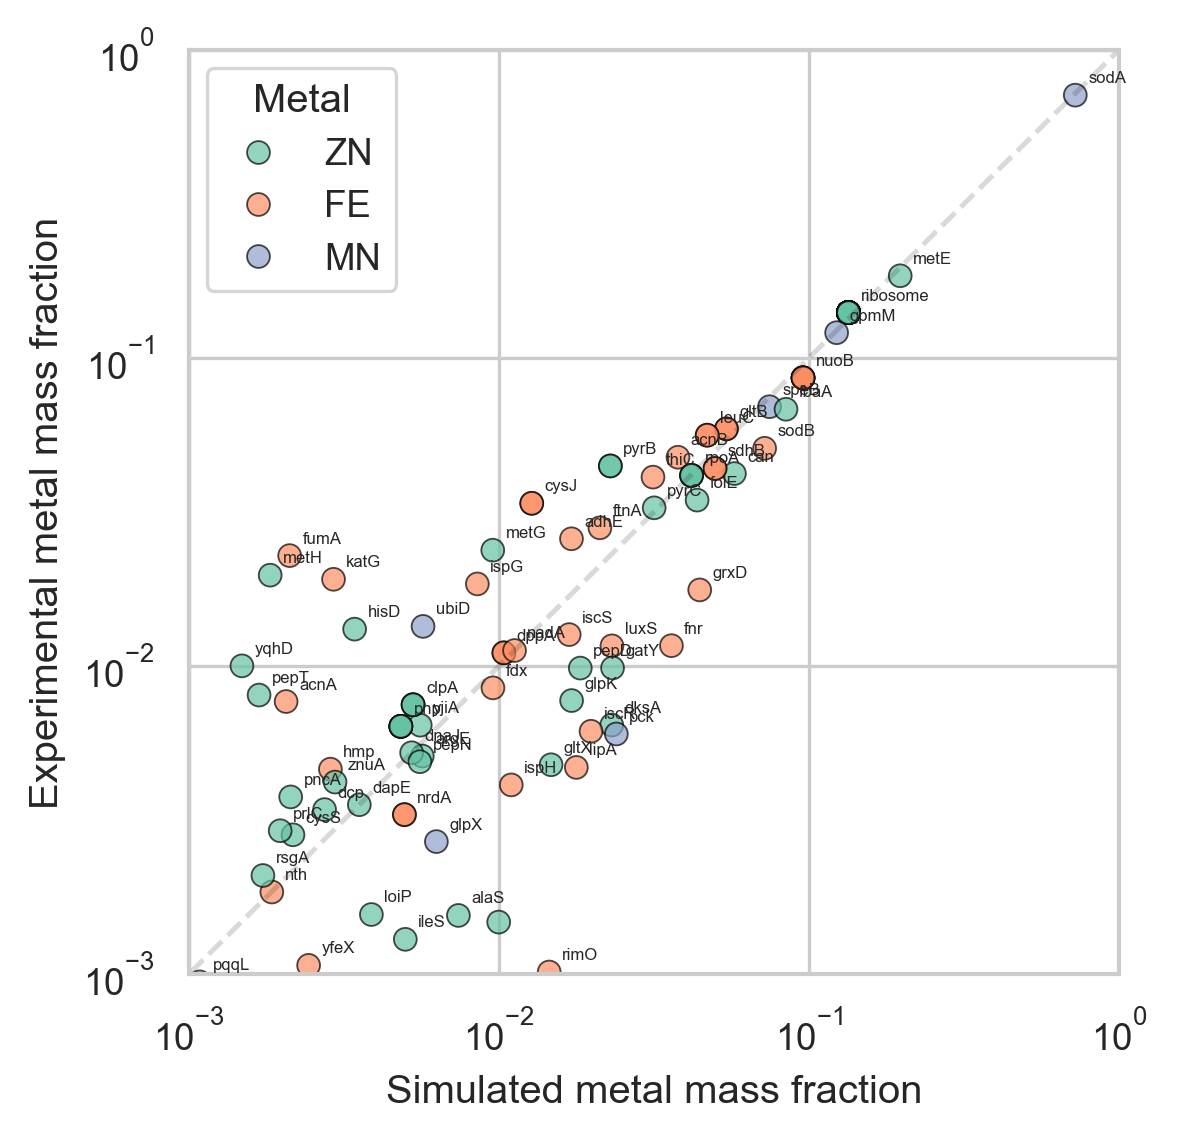

In [58]:
# plot
plt.figure(figsize=(4, 4))

cplx_gene_conversion = sim_metal_spec.select(["Complex ID", "Gene"]) 

# get all genes that have ribosome as cplx
rib_genes = cplx_gene_conversion.filter(pl.col("Complex ID") == "CPLX0-3964").select("Gene").to_numpy()[:,0].tolist()
# create mapping
rib_gene_mapping = {gene: "ribosome" for gene in rib_genes}

# if Complex ID is CPLX0-3964, change gene to ribosome
cplx_gene_conversion = cplx_gene_conversion.with_columns(pl.Series(name="Gene", values=cplx_gene_conversion["Gene"].replace(rib_gene_mapping)))

# join with exp_cplx_met_df
exp_cplx_met_plot_df = all_element_comp_df.join(cplx_gene_conversion, on="Complex ID")

sns.scatterplot(x="Simulated mass fraction", y="Experimental mass fraction", hue="Metal",
                data=exp_cplx_met_plot_df, alpha=0.7, s=30, edgecolor="black")

plt.xscale("log")
plt.yscale("log")

plt.xlim([1e-3, 1e-0])
plt.ylim([1e-3, 1e-0])

plt.xlabel(f"Simulated metal mass fraction")
plt.ylabel(f"Experimental metal mass fraction")


cplx_already_added = []
# below each point, plot the name of the protein
for i, txt in enumerate(exp_cplx_met_plot_df["Gene"].to_numpy()):
    cur_cplx = exp_cplx_met_plot_df["Complex ID"].to_numpy()[i]
    
    if cur_cplx not in cplx_already_added:
        plt.annotate(txt, (exp_cplx_met_plot_df["Simulated mass fraction"].to_numpy()[i] * 1.1, 
                           exp_cplx_met_plot_df["Experimental mass fraction"].to_numpy()[i] * 1.1), fontsize=4)
    
    cplx_already_added.append(cur_cplx)
    
# add x=y line
plt.plot([1e-5, 3e-0], [1e-5, 3e-0], color="black", linestyle="--", alpha=0.15)

# save to file
plt.savefig("figures/all_mass_scatter.svg")

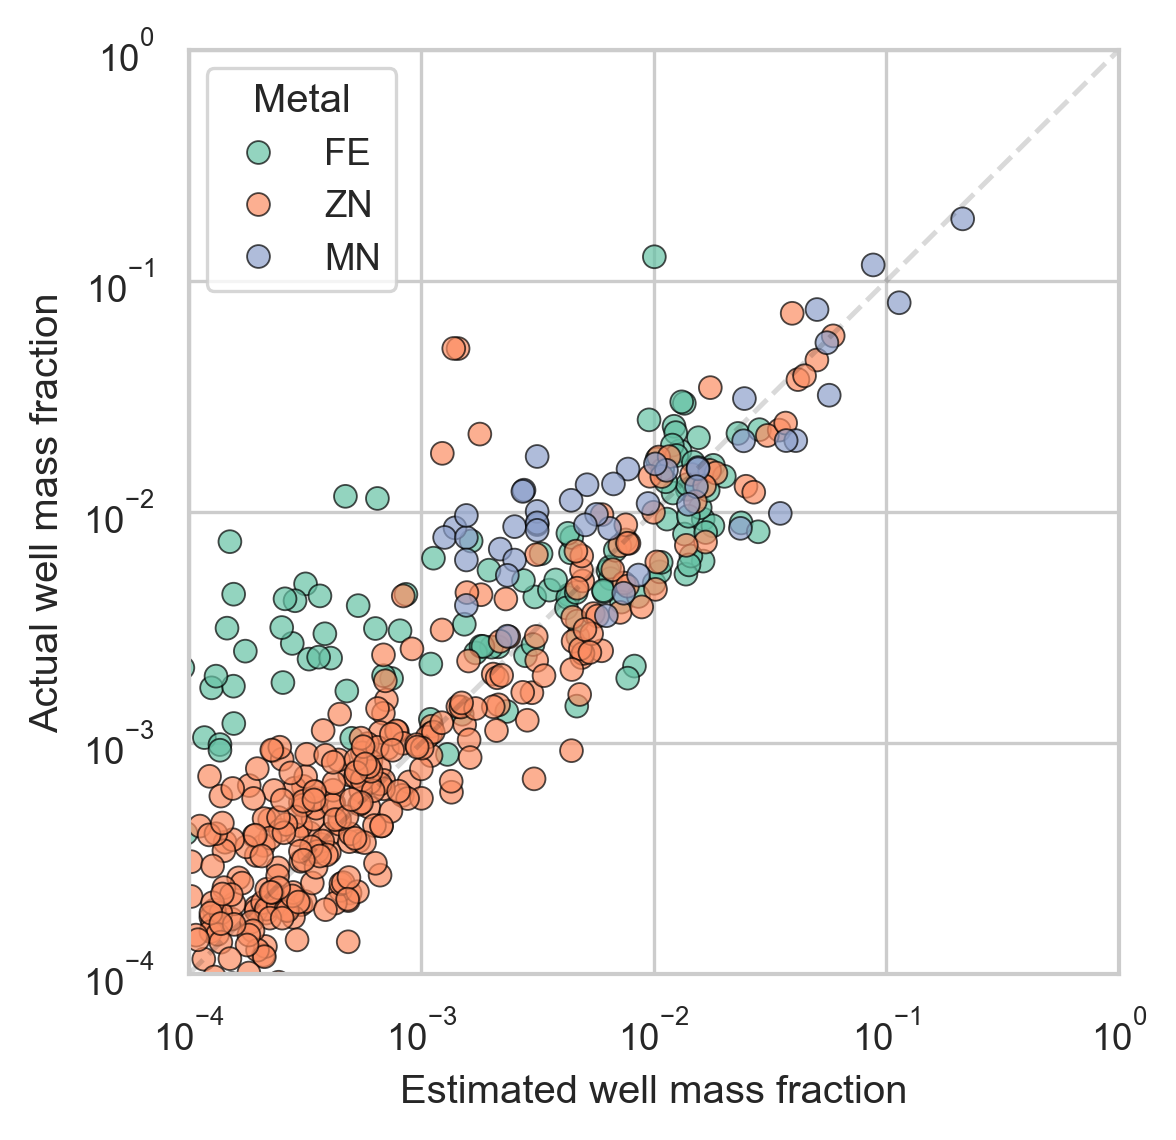

In [59]:
# plot scatter of data estimate
plt.figure(figsize=(4, 4))

sns.scatterplot(x="Estimated well mass fraction", y="Actual well mass fraction", hue="Metal", data=all_element_data_df, alpha=0.7, s=30, edgecolor="black")

plt.xscale("log")
plt.yscale("log")

plt.xlim([1e-4, 1e-0])
plt.ylim([1e-4, 1e-0])

# add x=y line
plt.plot([1e-5, 3e-0], [1e-5, 3e-0], color="black", linestyle="--", alpha=0.15)

# save as svg
plt.savefig("figures/all_data_estimate_scatter.svg")

In [60]:
lambda_vals

array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])

In [61]:
data_residuals

array([[0.352345  , 0.352345  , 0.35238353, 0.35381779, 0.4007344 ,
        0.60959239],
       [0.26496583, 0.26496604, 0.26503178, 0.26829677, 0.29366817,
        0.46381944],
       [0.33878224, 0.33878224, 0.33878224, 0.33878224, 0.37115041,
        0.4040259 ]])

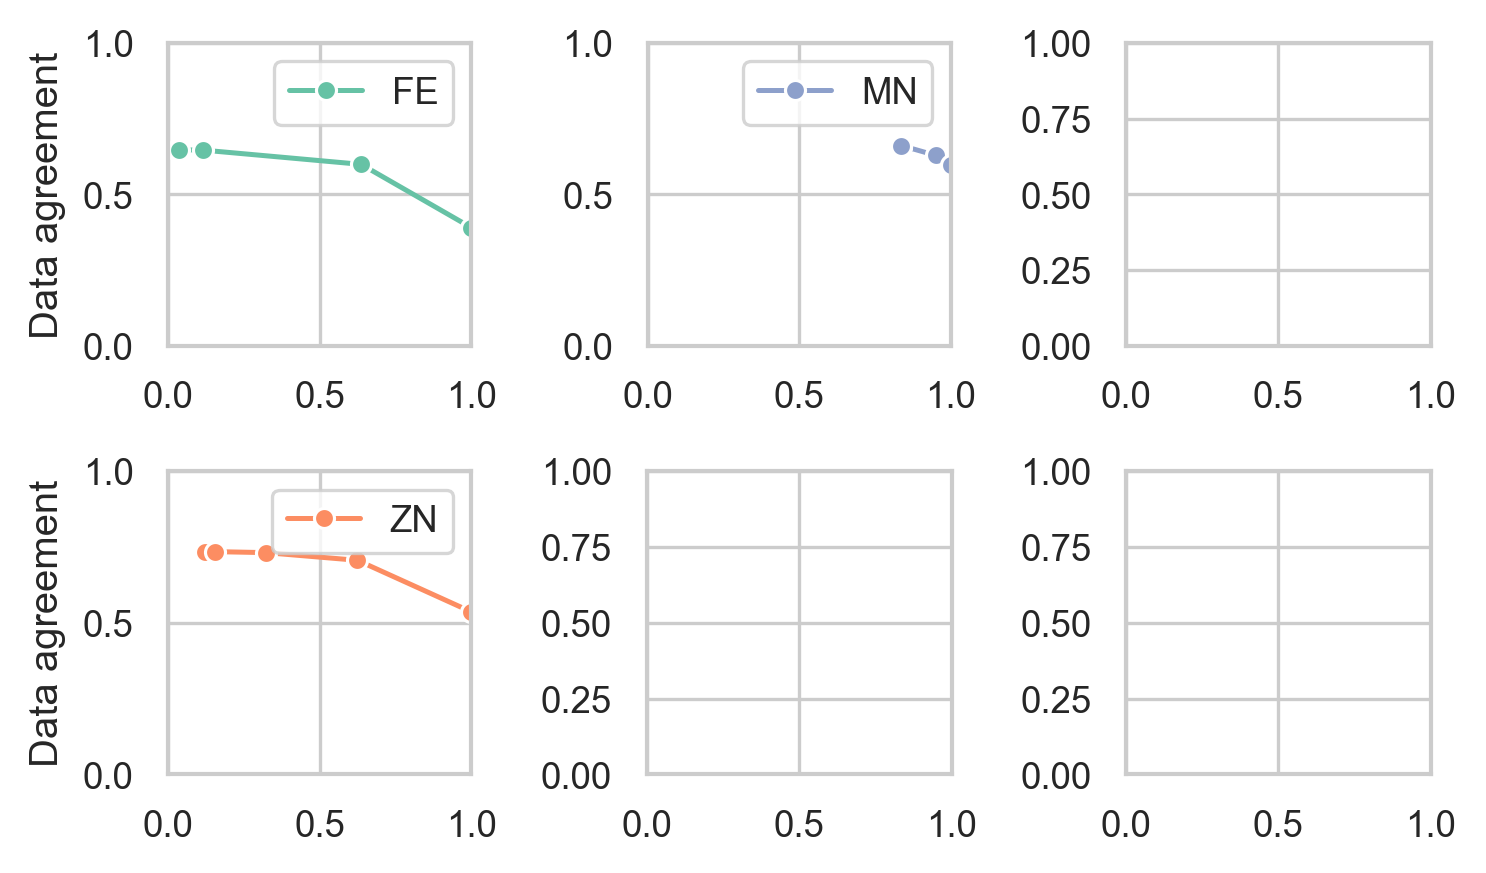

In [62]:
# plot residuals
f, ax = plt.subplots(2, 3, figsize=(5, 3), )

# create color palette
palette = sns.color_palette("Set2", len(lambda_vals))

for i, cur_metal in enumerate(metal_list):
    # convert i into subplot coords
    x = i % 2
    y = i // 2
    
    sns.lineplot(x=1 - sim_residuals[i, :], y=1 - data_residuals[i, :], 
                 label=metal_list[i], ax=ax[x,y], markers=True, marker="o", color=palette[i])
    
    ax[x,y].set_xlim([0, 1])
    ax[x,y].set_ylim([0, 1])
    
    # equal aspect
    ax[x,y].set_aspect('equal', adjustable='box')
    
    # identical tick markers
    ax[x,y].set_xticks(np.arange(0, 1.1, 0.5))
    ax[x,y].set_yticks(np.arange(0, 1.1, 0.5))
    
    # for i = 0 set y axis label, for i = 1 set x axis label
    if i == 0 or i == 1:
        ax[x,y].set_ylabel("Data agreement")
        
    if i == 3:
        ax[x,y].set_xlabel("Simulation agreement")
    
    # add a dot for the set of values at the third to last value
    # ax[i].scatter(1 - sim_residuals[i, -3], 1 - data_residuals[i, -3], color="black")
    
plt.tight_layout()

# save to svg
f.savefig("figures/residuals.svg", transparent=True)

# Check out some rare elements

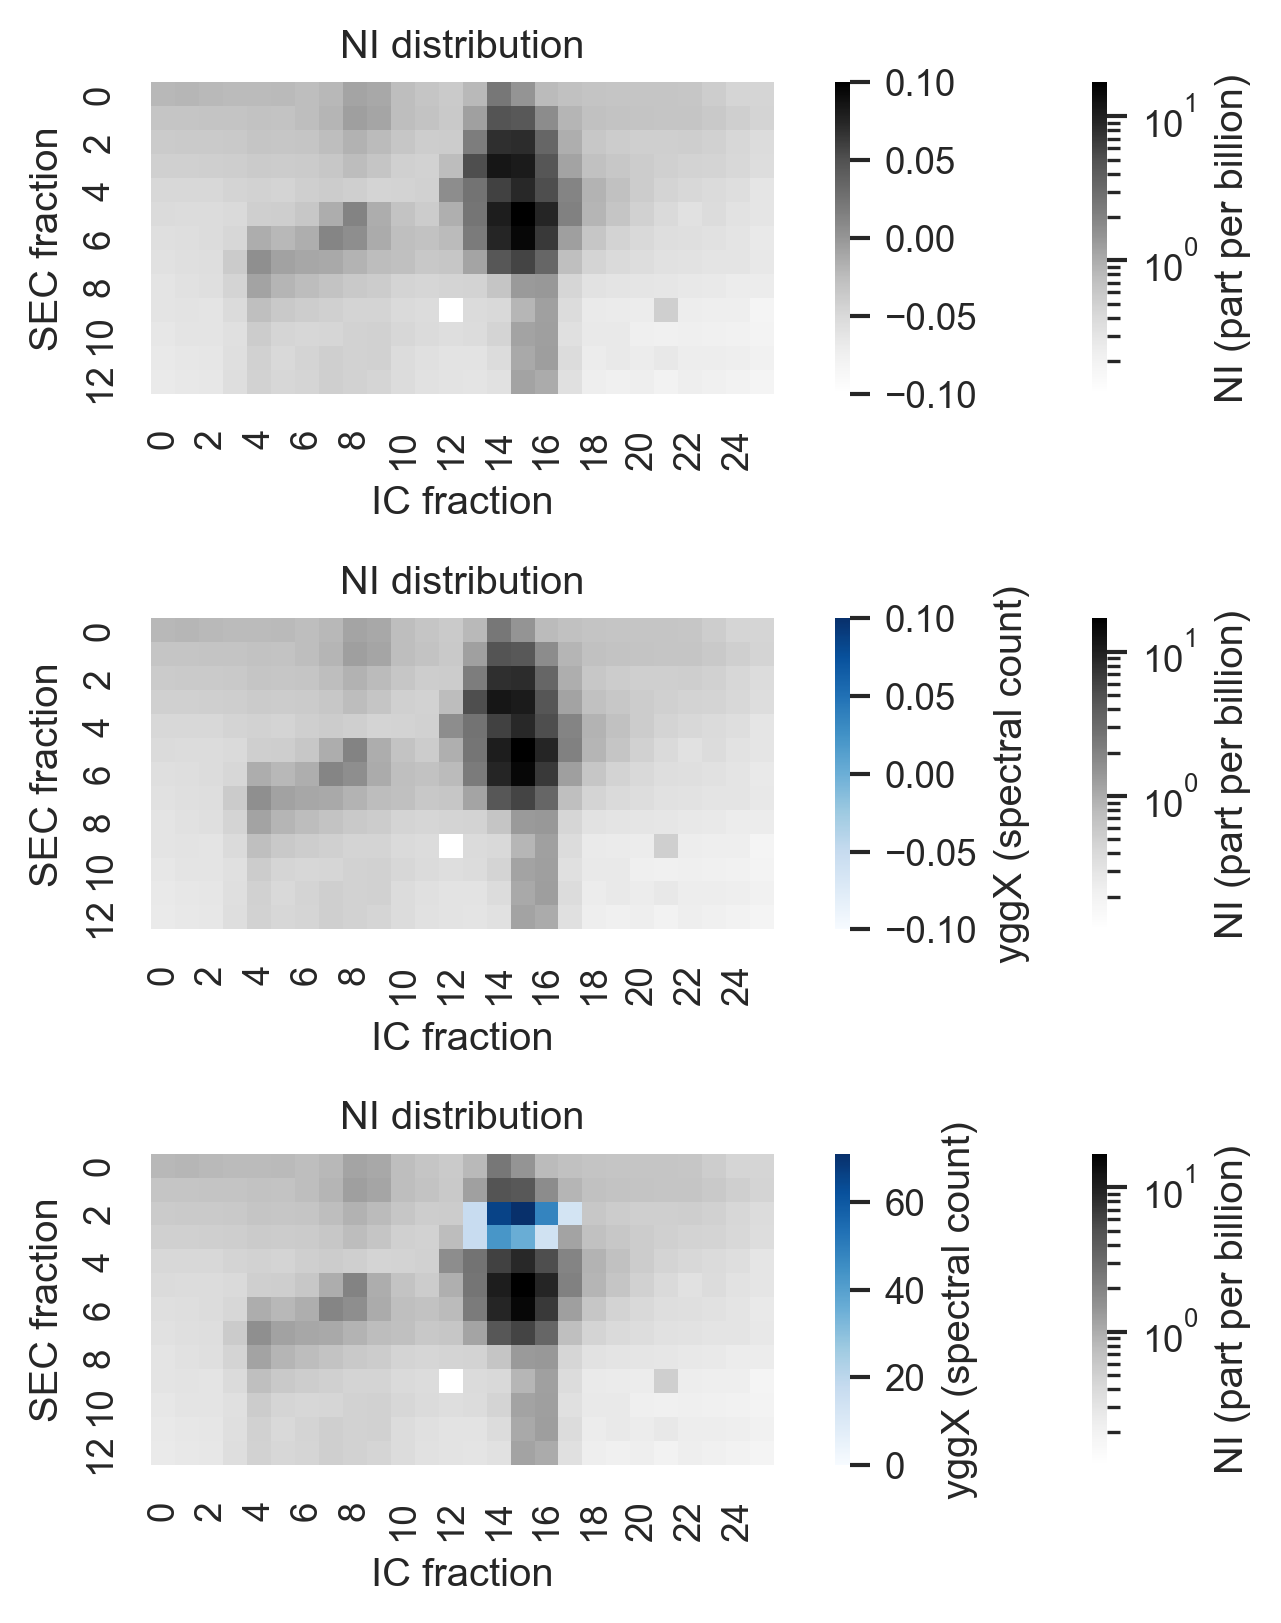

In [76]:
from matplotlib.colors import LogNorm
# plt.figure(figsize=(12, 6))

f, ax = plt.subplots(3,1, figsize=(5.5, 5.5))

gene = "yggX"
metal = "60Ni"
metal2 = "60Ni"
metal3 = "60Ni"
metal_translated = isotope_element_mapping[metal]
metal_translated2 = isotope_element_mapping[metal2]
metal_translated3 = isotope_element_mapping[metal3]

# heatmap of 56Fe data against x and y
sns.heatmap(metal_join_df.pivot(metal, "x", "y", )[:, 1:], cmap="Grays", square=True, cbar=True,
            norm=LogNorm(), 
            cbar_kws={'label': f'{metal_translated} (part per billion)'}, ax=ax[0])
sns.heatmap(prot_df.pivot(gene, "x", "y", )[:, 1:], mask=(prot_df.pivot(gene, "x", "y", ) < 1000).to_numpy()[:, 1:],
            cmap="Grays", square=True, cbar=True, vmin=0,  cbar_kws={'label': f' '}, ax=ax[0])

# add x and y labels
ax[0].set_ylabel("SEC fraction")
ax[0].set_xlabel("IC fraction")


sns.heatmap(metal_join_df.pivot(metal2, "x", "y", )[:, 1:], cmap="Grays", square=True,cbar=True, 
            norm=LogNorm(), 
            cbar_kws={'label': f'{metal_translated2} (part per billion)'}, ax=ax[1])
sns.heatmap(prot_df.pivot(gene, "x", "y", )[:, 1:], mask=(prot_df.pivot(gene, "x", "y", ) < 1000).to_numpy()[:, 1:],
            cmap="Blues", square=True, cbar=True, vmin=0,  cbar_kws={'label': f'{gene} (spectral count)'}, ax=ax[1])


# add x and y labels
ax[1].set_ylabel("SEC fraction")
ax[1].set_xlabel("IC fraction")

sns.heatmap(metal_join_df.pivot(metal3, "x", "y", )[:, 1:], cmap="Grays", square=True,cbar=True, 
            norm=LogNorm(), 
            cbar_kws={'label': f'{metal_translated3} (part per billion)'}, ax=ax[2])
sns.heatmap(prot_df.pivot(gene, "x", "y", )[:, 1:], mask=(prot_df.pivot(gene, "x", "y", ) < 1).to_numpy()[:, 1:],
            cmap="Blues", square=True, cbar=True, vmin=0,  cbar_kws={'label': f'{gene} (spectral count)'}, ax=ax[2])


# add x and y labels
ax[2].set_ylabel("SEC fraction")
ax[2].set_xlabel("IC fraction")

# add subplot titles
ax[0].set_title(f"{metal_translated} distribution")
ax[1].set_title(f"{metal_translated2} distribution")
ax[2].set_title(f"{metal_translated3} distribution")



plt.tight_layout()

# save as png and svg
#plt.savefig("figures/cu.png")
# plt.savefig("figures/zn_bare.svg")


In [64]:
|intensity_sums = prot_df.melt(id_vars=["Experiment", "x", "y"], variable_name="Gene", value_name="Intensity").group_by("Gene").agg(pl.sum("Intensity")).sort("Intensity")

# change name to intensity_sum
intensity_sums = intensity_sums.rename({"Intensity": "Intensity sum"})

mo_filter = prot_df.filter((pl.col("x") == 8)).filter((pl.col("y") == 14) | (pl.col("y") == 15) | (pl.col("y") == 16))

# melt 
mo_filter = mo_filter.melt(id_vars=["Experiment", "x", "y"], variable_name="Gene", value_name="Intensity")

# remove zero values
mo_filter = mo_filter.filter(pl.col("Intensity") > 0)

# groupby gene and sum
mo_filter = mo_filter.group_by("Gene").agg(pl.sum("Intensity"))

# pick unique genes
mo_filter = mo_filter.unique("Gene")

# join with intensity sums
mo_filter = mo_filter.join(intensity_sums, on="Gene")

# calculate the fraction of total intensity
mo_filter = mo_filter.with_columns(pl.Series(name="Fraction of total intensity", values=mo_filter["Intensity"] / mo_filter["Intensity sum"]))

# remove genes with fraction < 0.1
mo_filter = mo_filter.filter(pl.col("Fraction of total intensity") > 0.2)

mo_filter

Gene,Intensity,Intensity sum,Fraction of total intensity
str,i64,i64,f64
"""cmoM""",2,2,1.0
"""apaH""",2,2,1.0
"""btuR""",3,3,1.0
"""ymfK""",2,4,0.5
"""cysE""",6,6,1.0
…,…,…,…
"""opgG""",62,189,0.328042
"""yeiP""",58,217,0.267281
"""bioD""",68,234,0.290598


# Highlight number of wells not explainable

In [65]:
element_unexplained_dict = {}

for cur_metal in elements:
    # cur_metal = "CU"
    
    # find complexes with metal
    cplx_has_metal = sim_prot_metal_df.group_by("Complex ID").agg(pl.sum(cur_metal))
    
    # rename metal col to "Complex has metal"
    cplx_has_metal = cplx_has_metal.rename({cur_metal: "Complex has metal"})
    
    # convert to boolean
    cplx_has_metal = cplx_has_metal.with_columns(pl.Series(name="Complex has metal", values=cplx_has_metal["Complex has metal"] > 0))
    
    # join
    sim_metal_spec = sim_prot_metal_df.join(cplx_has_metal, on="Complex ID")
    
    # filter to only include detected proteins
    sim_metal_spec = sim_metal_spec.filter(pl.col("Protein ID").is_in(detected_protein_ids))
    
    prof_df_gene_order = prot_df.drop(["Experiment", "x", "y"]).columns
    
    # only pick out the genes that are in the gene_indices
    prot_df_gene_order = [gene for gene in prof_df_gene_order if gene in gene_to_prot_dict]
    
    M = prot_df.drop(["Experiment", "x", "y"]).to_numpy()[:, gene_indices]
    
    # for each gene in prot_df_gene_order, pick out the corresponding index in sim_metal_spec
    # and get the "Complex has metal" value
    m_filter = np.zeros(len(detected_protein_ids))
    
    for i, gene in enumerate(prot_df_gene_order):
        if gene in sim_metal_spec["Gene"]:
            m_filter[i] = sim_metal_spec.filter(pl.col("Gene") == gene).select("Complex has metal").to_numpy()[0,0]
    
    # n_well x n_prot matrix of normalized intensities
    # n_well x 1 vector of metal masses 
    # n_prot x 1 vector of protein counts (variable) times per protein stoichiometry
    
    M = prot_df.drop(["Experiment", "x", "y"]).to_numpy()[:, gene_indices]
    
    gene_names_filtered = np.array(gene_names)[gene_indices].tolist()
    
    # set dtype to float64
    M = M.astype(np.float64)
    
    # change nans to 0
    M[np.isnan(M)] = 0
    
    # normalize the matrix so each col sums to 1
    col_sums = M.sum(axis=0)
    M = M / col_sums
    
    # change nans to 0
    M[np.isnan(M)] = 0
    
    # get the Zn vector
    m_vec = metal_join_df[element_isotope_mapping[cur_metal]].to_numpy()
    
    # normalize m_vec
    m_vec = m_vec / m_vec.sum()
    
    # get the filter for proteins that have Zn
    element_idx = elements.index(cur_metal)
    # m_filter = PE_detected[:, element_idx].toarray().flatten()
    
    
    
    n_cplx_filt = sim_metal_spec.unique("Complex ID").shape[0]
    cplx_names_mix = sim_metal_spec.unique("Complex ID").select("Complex ID").to_numpy()[:,0].tolist()
    
    # create a monomer to complex matrix for comparing to sim
    C_mixed = np.zeros([n_cplx_filt, len(gene_names_filtered)])
    
    # for each gene, find the corresponding complex id in sim_metal_spec
    for i, gene in enumerate(gene_names_filtered):
        cplx_id = sim_metal_spec.filter(pl.col("Gene") == gene).select("Complex ID").to_numpy()[0,0]
        cplx_idx = cplx_names_mix.index(cplx_id)
        
        C_mixed[cplx_idx, i] = 1
        
        
        
    sim_cplx_met_agg = sim_metal_spec.group_by("Complex ID").agg(pl.sum(cur_metal))
    
    sim_cplx_met_agg.sort(cur_metal)
    
    # create target vec
    cplx_agg_vec = np.zeros(n_cplx_filt)
    
    # for each complex, find the corresponding index in sim_metal_spec, set the value to the Zn value
    for i, cplx_id in enumerate(cplx_names_mix):
        cplx_agg_vec[i] = sim_cplx_met_agg.filter(pl.col("Complex ID") == cplx_id).select(cur_metal).to_numpy()[0,0]
        
        
        
    counts = cp.Variable(len(detected_protein_ids))
    
    # create the constraints
    constr = []
    constr.append(counts >= 0)
    
    obj = cp.norm1( M @ cp.multiply(counts, m_filter) - m_vec) 
    obj += 1 * cp.norm2(C_mixed @ counts - cplx_agg_vec) 
    obj += 0.000001 * cp.sum(counts)
    
    prob = cp.Problem(cp.Minimize(obj), constr,)
    prob.solve( solver="CLARABEL")
    
    counts_solved = counts.value
    
    
    
    
    
    # create complex assignments
    exp_cplx_met_assign = C_mixed @ counts_solved
    
    # normalize by sum
    exp_cplx_met_assign = exp_cplx_met_assign  # / exp_cplx_met_assign.sum()
    
    # create a dataframe
    exp_cplx_met_df = pl.DataFrame(exp_cplx_met_assign, schema=["Mass"])
    
    # add complex id
    exp_cplx_met_df = exp_cplx_met_df.with_columns(pl.Series(name="Complex ID", values=cplx_names_mix))
    
    # join with sim_metal_spec
    exp_cplx_met_df = exp_cplx_met_df.join(sim_cplx_met_agg.select(["Complex ID", cur_metal]), on="Complex ID")
    
    # filter out rows where ZN is 0
    exp_cplx_met_df = exp_cplx_met_df.filter((pl.col(cur_metal) > 0) & (pl.col("Mass") > 0))
    
    
    
    print(np.abs( M @ np.multiply(counts_solved, m_filter) - m_vec ).sum())
    print(np.abs( C_mixed @ counts_solved - cplx_agg_vec ).sum())
    
    n_wells_unexplained =  (np.sort(m_vec - M @ np.multiply(counts_solved, m_filter)) > 0.01).sum()
    
    print(f"Number of wells unexplained: {n_wells_unexplained.sum()} for metal {cur_metal}")
    
    element_unexplained_dict[cur_metal] = n_wells_unexplained
    

0.6469092858748133
0.3925204394712618
Number of wells unexplained: 1 for metal FE
0.3119246443733341
0.4007368353942727
Number of wells unexplained: 5 for metal ZN
0.9342510120101859
0.5262583235620354
Number of wells unexplained: 2 for metal MN
1.2308577188301444
0.022590300582967193
Number of wells unexplained: 25 for metal CU
0.926846925097251
0.7158845980320552
Number of wells unexplained: 7 for metal MO
1.0000489266008368
0.7544636682128044
Number of wells unexplained: 19 for metal NI


<Axes: xlabel='Element', ylabel='Wells unexplained'>

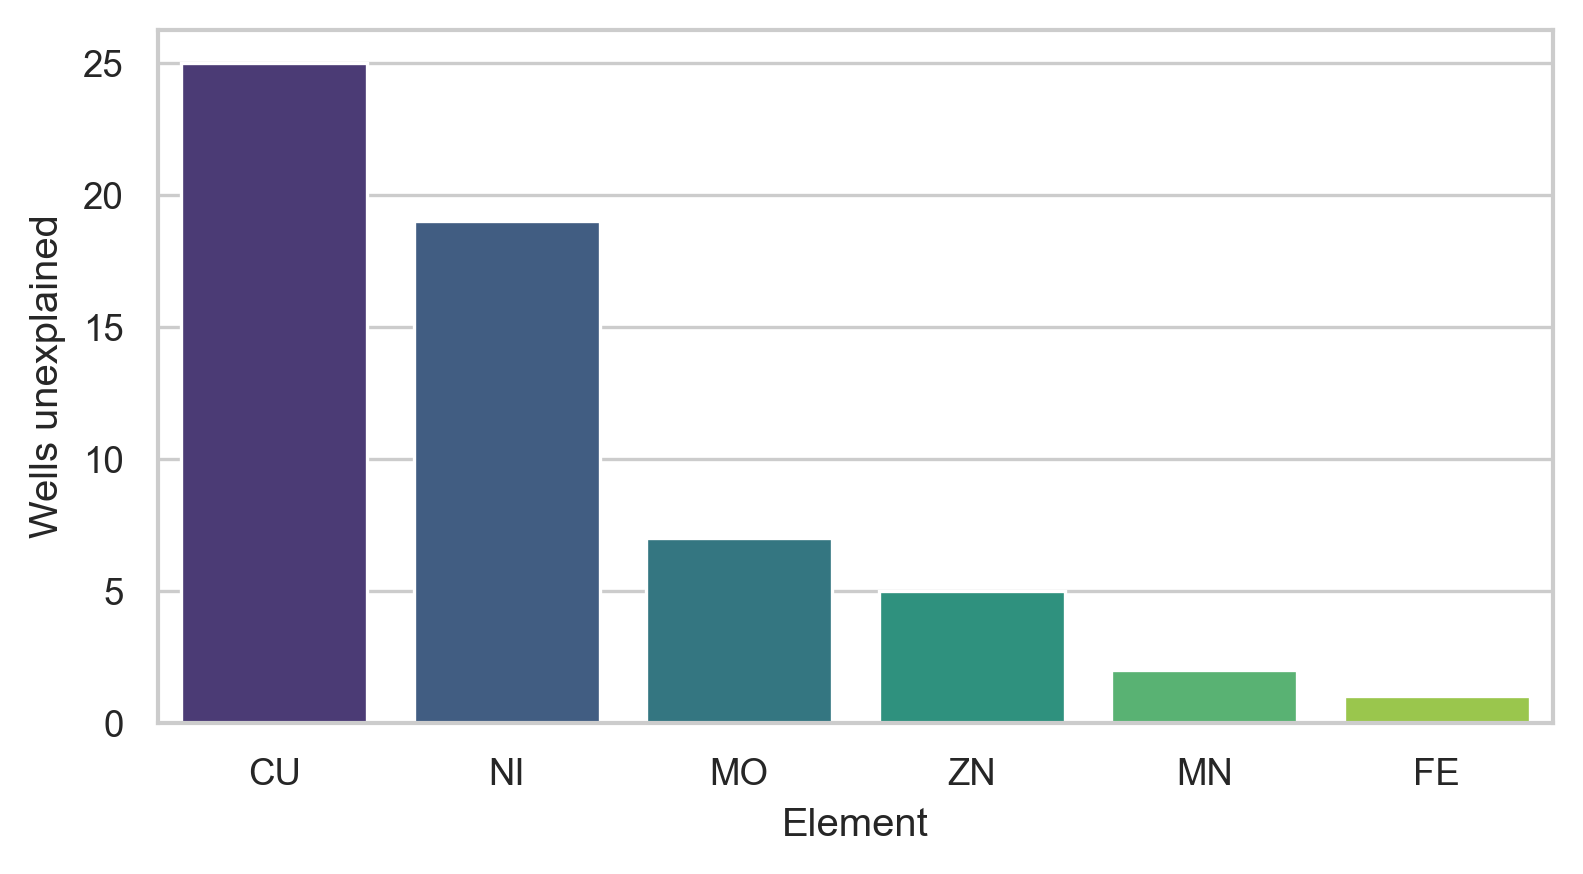

In [66]:
# plot the number of wells unexplained as bar plot
plt.figure(figsize=(6, 3))

# convert to df
element_unexplained_df = pl.DataFrame(element_unexplained_dict)
element_unexplained_df = element_unexplained_df.melt(variable_name="Element", value_name="Wells unexplained")

# sort by wells unexplained
element_unexplained_df = element_unexplained_df.sort("Wells unexplained", descending=True)


# make plot
sns.barplot(data=element_unexplained_df, x="Element", y="Wells unexplained", palette="viridis")

# Intersect Ni, Co, Mn

In [67]:

ni_intersect = metal_join_df.pivot("60Ni", "x", "y", )[:, 1:].to_numpy() 
co_intersect = metal_join_df.pivot("59Co", "x", "y", )[:, 1:].to_numpy()
mn_intersect = metal_join_df.pivot("55Mn", "x", "y", )[:, 1:].to_numpy()

v_intersect = metal_join_df.pivot("51V", "x", "y", )[:, 1:].to_numpy()
w_intersect = metal_join_df.pivot("182W", "x", "y", )[:, 1:].to_numpy()

# subtract min
ni_intersect = ni_intersect - np.median(ni_intersect)
co_intersect = co_intersect - np.median(co_intersect)
mn_intersect = mn_intersect - np.median(mn_intersect)
v_intersect = v_intersect - np.median(v_intersect)
w_intersect = w_intersect - np.median(w_intersect)

# if negative, set to 0.00001
ni_intersect[ni_intersect < 0] = 0.0000001
co_intersect[co_intersect < 0] = 0.0000001
mn_intersect[mn_intersect < 0] = 0.0000001
v_intersect[v_intersect < 0] = 0.0000001
w_intersect[w_intersect < 0] = 0.0000001

yggx_intersect = prot_df.pivot("yggX", "x", "y", )[:, 1:].to_numpy()

In [68]:
# multiply elementwise 
intersect = (ni_intersect * co_intersect * mn_intersect)**(1/3)

<Axes: >

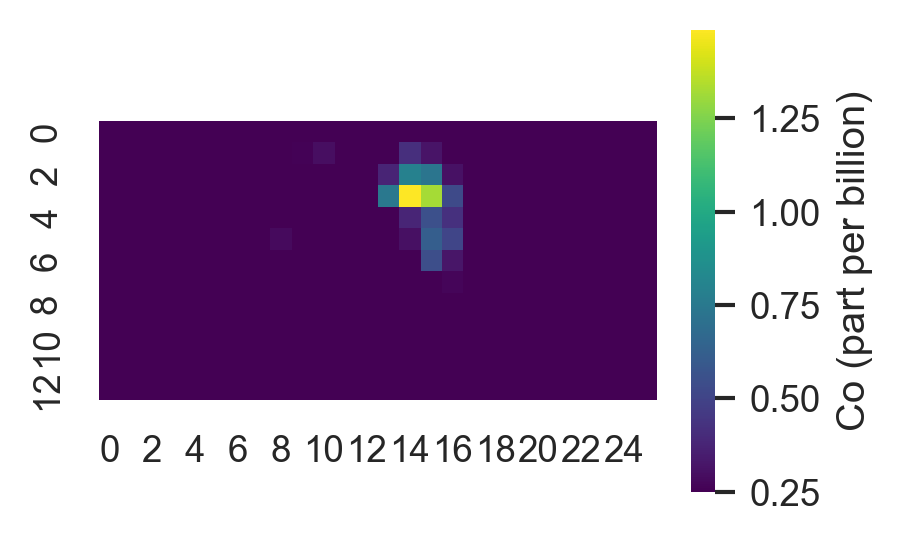

In [69]:
# plot co values above median
plt.figure(figsize=(3, 2))

sns.heatmap(intersect, cmap="viridis", square=True, cbar=True, cbar_kws={'label': 'Co (part per billion)'}, vmin=0.25)

<Axes: >

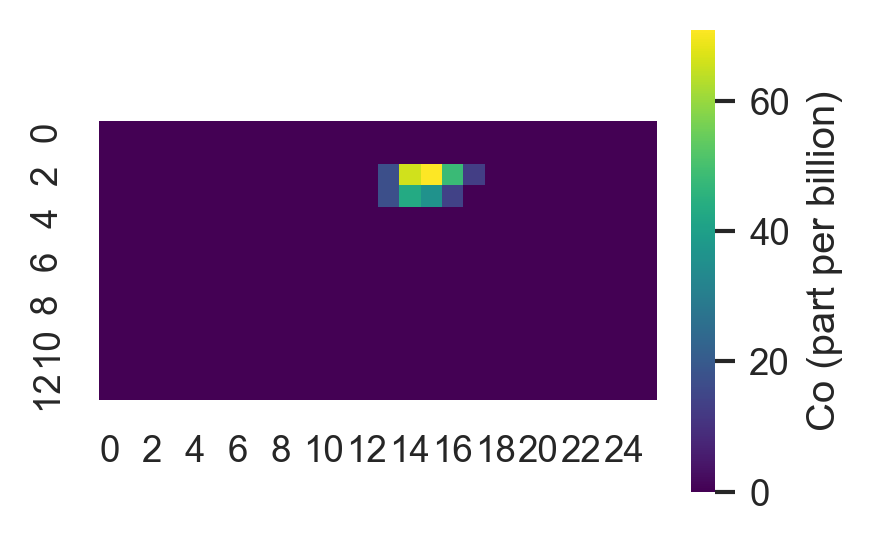

In [70]:
# plot co values above median
plt.figure(figsize=(3, 2))

sns.heatmap(yggx_intersect, cmap="viridis", square=True, cbar=True, cbar_kws={'label': 'Co (part per billion)'})

<Axes: >

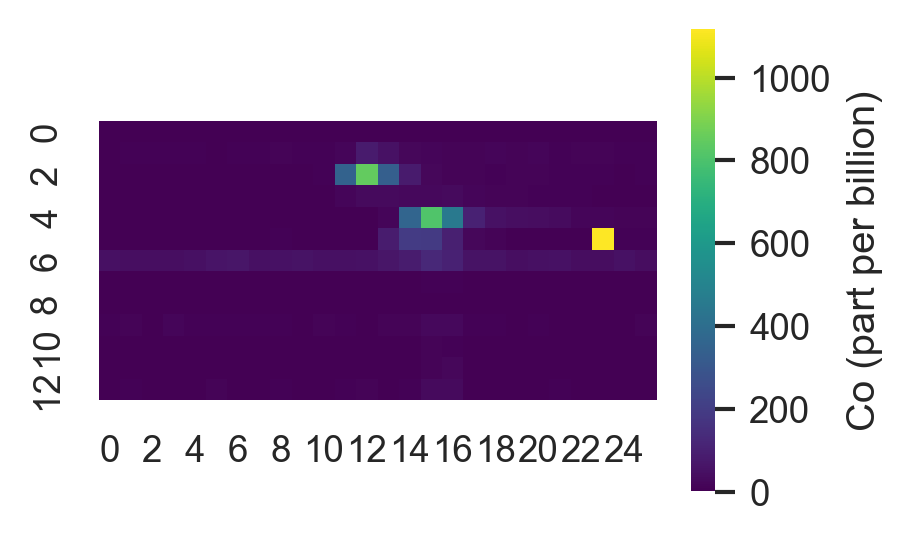

In [71]:
# plot co values above median
plt.figure(figsize=(3, 2))

sns.heatmap(w_intersect, cmap="viridis", square=True, cbar=True, cbar_kws={'label': 'Co (part per billion)'})